In [1]:
# Command to reload all modules before executing the code
%load_ext autoreload 
%autoreload 2

In [2]:
# ML libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Utils
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import warnings
from typing import List, Dict, Any, Tuple, Union, Optional, Callable, TypeVar
# Project modules
pass

warnings.filterwarnings('ignore')

C:\Users\timot\AppData\Local\Temp\ipykernel_24600\3779753175.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Comparison of the distributions in train vs in test

In this notebook, we unsure the train distribution match the test distribution. We will plot the train and test distribution of each metric averaged side by side, and also put in evidence the metrics whose train vs test distribution is most different according to our criteria.

## Team features

In [3]:
from src.data_loading import load_dataframe_teamfeatures
df_teamfeatures_train = load_dataframe_teamfeatures('train')
df_teamfeatures_test = load_dataframe_teamfeatures('test')

We plot the top 10 metrics season averaged distributions for train in test, in terms of difference between the two distributions.

Missing season_average for HOME_ID
Missing season_average for HOME_LEAGUE
Missing season_average for HOME_TEAM_NAME
Missing season_average for AWAY_ID
Missing season_average for AWAY_LEAGUE
Missing season_average for AWAY_TEAM_NAME
AWAY_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 7.718526228141981 (loss = l1_loss)


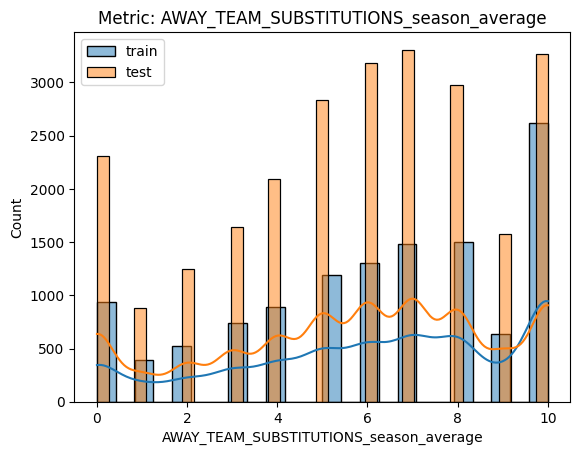

HOME_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 6.693791003348803 (loss = l1_loss)


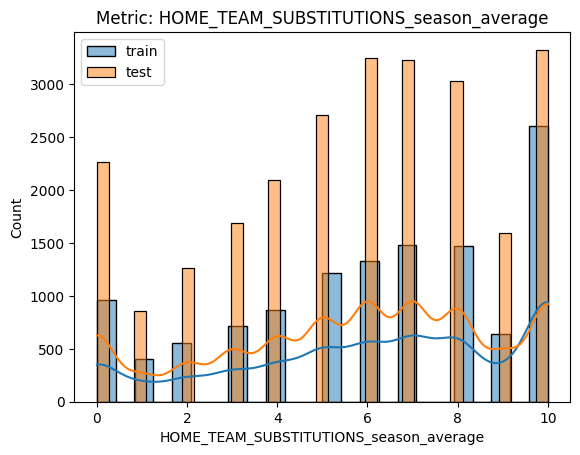

HOME_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.543590933476699 (loss = l1_loss)


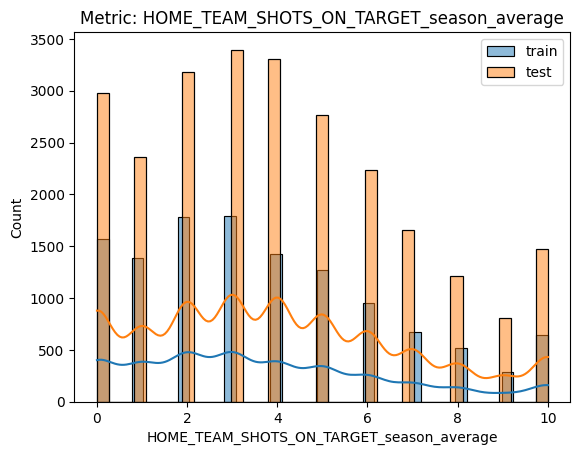

HOME_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.148285692562689 (loss = l1_loss)


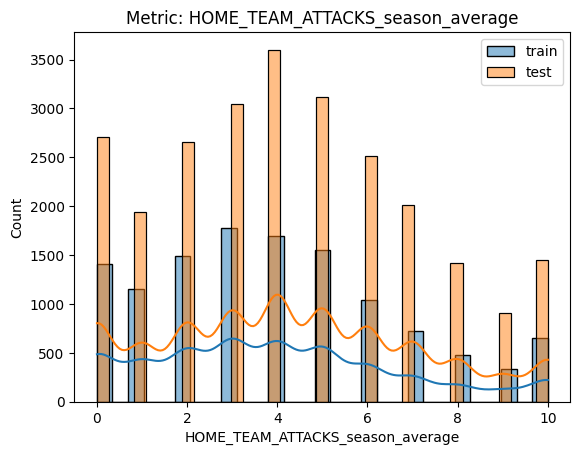

AWAY_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.013796278455576 (loss = l1_loss)


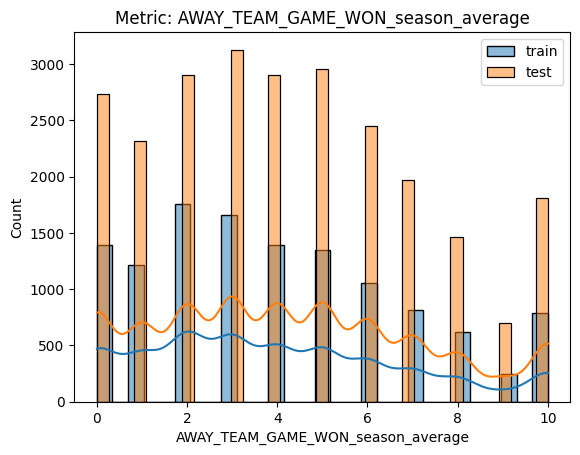

AWAY_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.96258967816353 (loss = l1_loss)


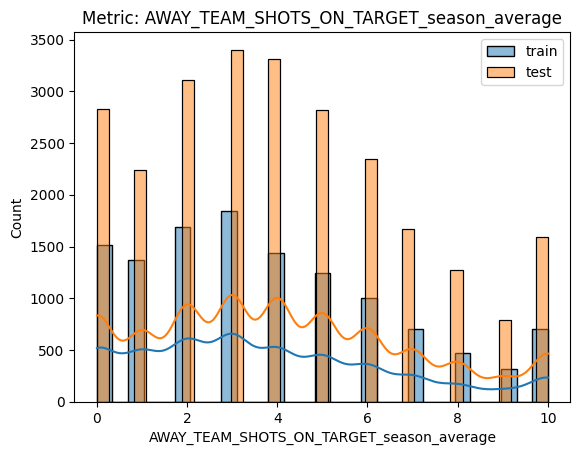

AWAY_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.956650942597053 (loss = l1_loss)


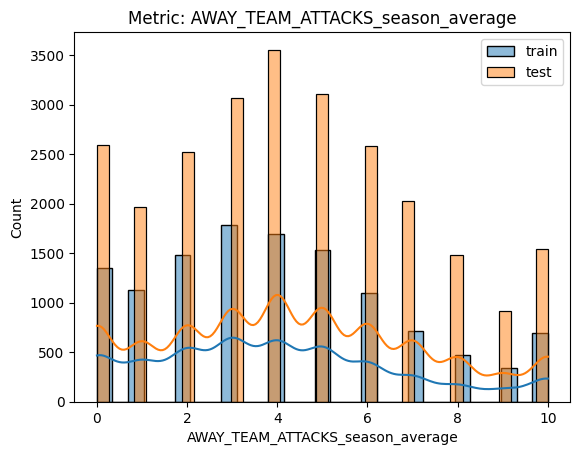

HOME_TEAM_DANGEROUS_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.398058010748571 (loss = l1_loss)


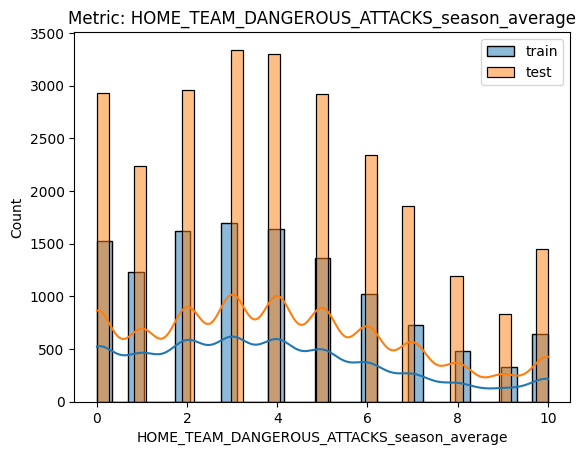

HOME_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.280673415904634 (loss = l1_loss)


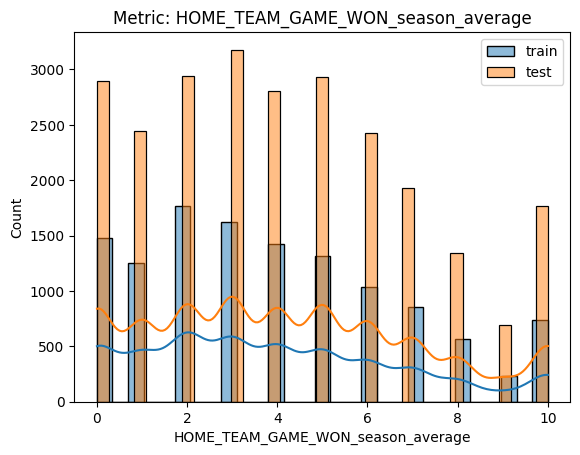

AWAY_TEAM_SHOTS_INSIDEBOX_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.058877086366639 (loss = l1_loss)


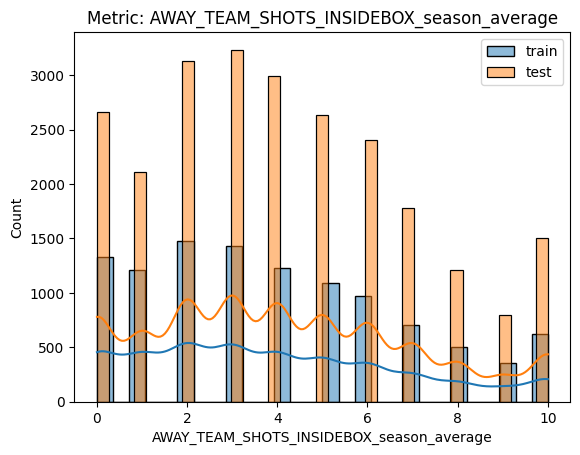

In [27]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures_train)
metric_names_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    # Compute the distribution difference
    column_name = f"{metric_name}_season_average"
    metric_names_to_loss_name_to_loss_values[column_name] = compute_distribution_difference(
        feature_serie1=df_teamfeatures_train[column_name],
        feature_serie2=df_teamfeatures_test[column_name],
        n_monte_carlo=1,
        n_value_max=50,
        normalization_method='mc_estimated_loss',
        )

# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10

for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_STATISTIC}) : {loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]} (loss = {LOSS_NAME})")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {column_name}")
    sns.histplot(df_teamfeatures_train[column_name], kde=True, label="train")
    sns.histplot(df_teamfeatures_test[column_name], kde=True, label="test")
    plt.legend()
    plt.show()

We plot here the distribution of those differences.

As we can see, if LOSS_STATISTIC = 'loss_value_normalized', a lot of metrics have a notably superior to 1 normalized difference, which means that the train and test distributions are notably different.

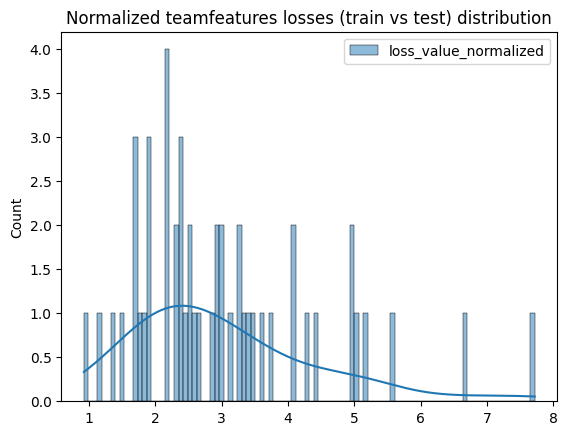

In [28]:
LOSS_NAME = 'l1_loss'
LOSS_STATISTIC = 'loss_value_normalized'

loss_value_normalized_values = list(metric_names_to_loss_name_to_loss_values.values())
loss_value_normalized_values = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values]
fig, ax = plt.subplots()
ax.set_title(f"Normalized teamfeatures losses (train vs test) distribution")
sns.histplot(loss_value_normalized_values, kde=True, label="loss_value_normalized", bins=100)
plt.legend()

Below, we plot not the tops, but all double distributions of the team features.

Missing season_average for HOME_ID
Missing season_average for HOME_LEAGUE
Missing season_average for HOME_TEAM_NAME


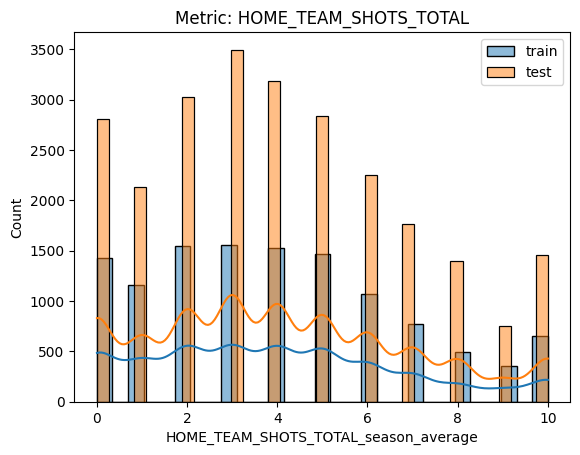

Metric: HOME_TEAM_SHOTS_TOTAL
Differences: {'l1_loss': {'loss_value': 0.0064780233751387025, 'estimated_typical_loss_value': 0.0022110341322058376, 'loss_value_normalized': 2.9298613172810923}, 'l2_loss': {'loss_value': 7.441352990697455e-05, 'estimated_typical_loss_value': 1.094739808257589e-05, 'loss_value_normalized': 6.797371333733024}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0775501745290432, 'estimated_typical_loss_value': 0.028431095593725874, 'loss_value_normalized': 2.7276533988425067}}


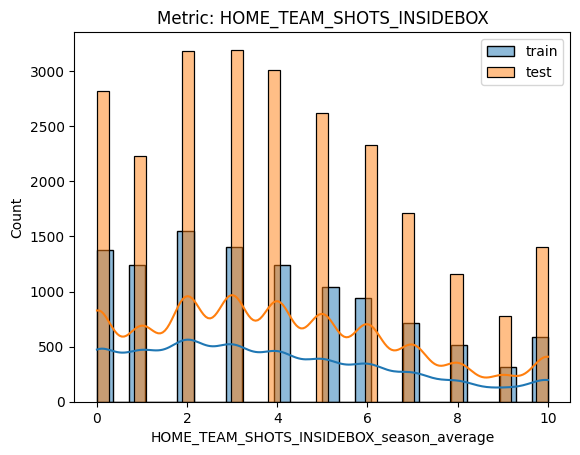

Metric: HOME_TEAM_SHOTS_INSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.007947728867618487, 'estimated_typical_loss_value': 0.00219383369929352, 'loss_value_normalized': 3.622758128921572}, 'l2_loss': {'loss_value': 0.00014205460231845487, 'estimated_typical_loss_value': 1.1003480306663843e-05, 'loss_value_normalized': 12.909970150949265}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.07102570919193898, 'estimated_typical_loss_value': 0.026807253663842966, 'loss_value_normalized': 2.6494959193726104}}


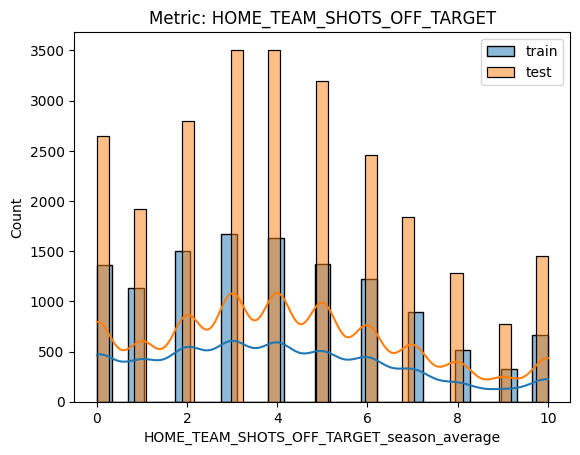

Metric: HOME_TEAM_SHOTS_OFF_TARGET
Differences: {'l1_loss': {'loss_value': 0.005055232599767007, 'estimated_typical_loss_value': 0.002263771718467795, 'loss_value_normalized': 2.2331017560322204}, 'l2_loss': {'loss_value': 6.268635712561146e-05, 'estimated_typical_loss_value': 9.112309064775966e-06, 'loss_value_normalized': 6.879305418469709}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06118652719916395, 'estimated_typical_loss_value': 0.02577626196618372, 'loss_value_normalized': 2.373754863270515}}


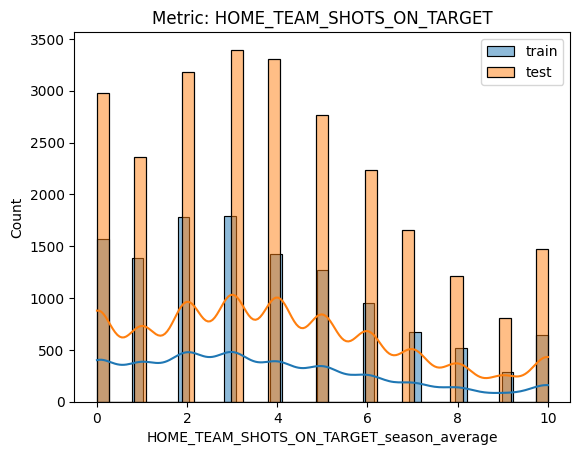

Metric: HOME_TEAM_SHOTS_ON_TARGET
Differences: {'l1_loss': {'loss_value': 0.010259129510034432, 'estimated_typical_loss_value': 0.00234670889349283, 'loss_value_normalized': 4.371709477251702}, 'l2_loss': {'loss_value': 0.00016056279454825718, 'estimated_typical_loss_value': 8.963661947444126e-06, 'loss_value_normalized': 17.91263386389334}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.12792357711918653, 'estimated_typical_loss_value': 0.027206629299487077, 'loss_value_normalized': 4.7019267146627834}}


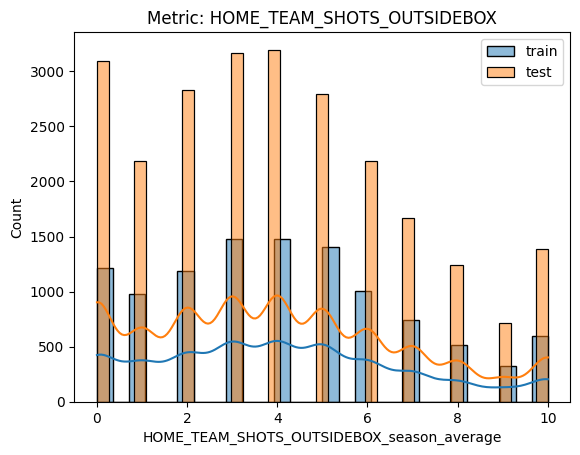

Metric: HOME_TEAM_SHOTS_OUTSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.004769222156803982, 'estimated_typical_loss_value': 0.002229878116057549, 'loss_value_normalized': 2.138781542569488}, 'l2_loss': {'loss_value': 4.536768381956051e-05, 'estimated_typical_loss_value': 9.825391551622868e-06, 'loss_value_normalized': 4.617391946180692}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04189394848411563, 'estimated_typical_loss_value': 0.025821033809111483, 'loss_value_normalized': 1.6224737085984577}}


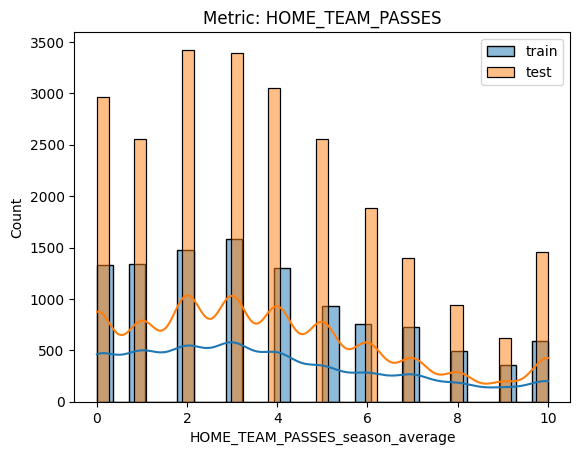

Metric: HOME_TEAM_PASSES
Differences: {'l1_loss': {'loss_value': 0.007767097141062299, 'estimated_typical_loss_value': 0.0022443672019893937, 'loss_value_normalized': 3.460706935200631}, 'l2_loss': {'loss_value': 9.179987801957085e-05, 'estimated_typical_loss_value': 9.824420520652249e-06, 'loss_value_normalized': 9.344050147743616}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.09726801884904149, 'estimated_typical_loss_value': 0.02756655711914461, 'loss_value_normalized': 3.528479034528739}}


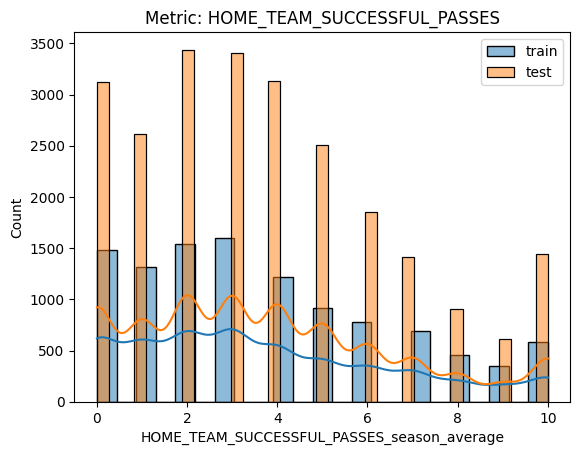

Metric: HOME_TEAM_SUCCESSFUL_PASSES
Differences: {'l1_loss': {'loss_value': 0.00822665852694848, 'estimated_typical_loss_value': 0.002258721908992962, 'loss_value_normalized': 3.6421741402488443}, 'l2_loss': {'loss_value': 0.00011859547200188435, 'estimated_typical_loss_value': 9.61725099251356e-06, 'loss_value_normalized': 12.331535497146275}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.09729824787655539, 'estimated_typical_loss_value': 0.028160906583027927, 'loss_value_normalized': 3.4550822286095904}}


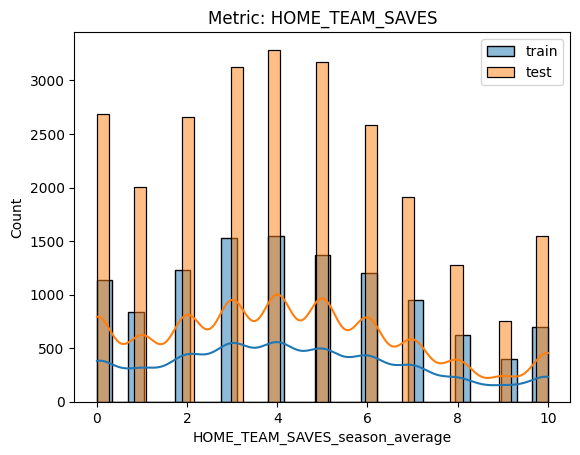

Metric: HOME_TEAM_SAVES
Differences: {'l1_loss': {'loss_value': 0.004231133329695131, 'estimated_typical_loss_value': 0.002279371103959195, 'loss_value_normalized': 1.856272250861378}, 'l2_loss': {'loss_value': 3.773735289962372e-05, 'estimated_typical_loss_value': 9.26649943072333e-06, 'loss_value_normalized': 4.072449707772089}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.044421274429526675, 'estimated_typical_loss_value': 0.026333363773100995, 'loss_value_normalized': 1.6868818891607666}}


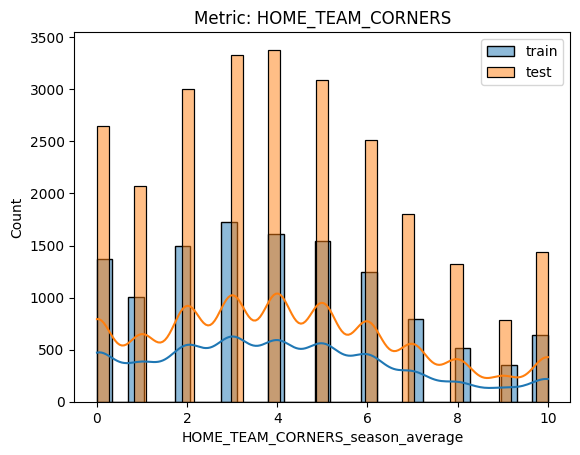

Metric: HOME_TEAM_CORNERS
Differences: {'l1_loss': {'loss_value': 0.004319928822986535, 'estimated_typical_loss_value': 0.0022561398551990417, 'loss_value_normalized': 1.9147433670972476}, 'l2_loss': {'loss_value': 2.7791829081513653e-05, 'estimated_typical_loss_value': 1.1097236017852913e-05, 'loss_value_normalized': 2.504391997813408}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06251734461178186, 'estimated_typical_loss_value': 0.02678520765403368, 'loss_value_normalized': 2.334025011837705}}


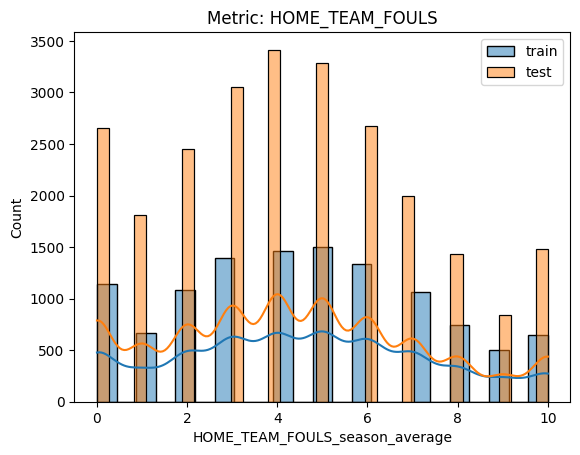

Metric: HOME_TEAM_FOULS
Differences: {'l1_loss': {'loss_value': 0.006762275463538137, 'estimated_typical_loss_value': 0.0023933765334061816, 'loss_value_normalized': 2.825412286429349}, 'l2_loss': {'loss_value': 8.05603366955621e-05, 'estimated_typical_loss_value': 1.0261215110530612e-05, 'loss_value_normalized': 7.850954865096189}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.07405779361775601, 'estimated_typical_loss_value': 0.025061394112591305, 'loss_value_normalized': 2.9550548259622698}}


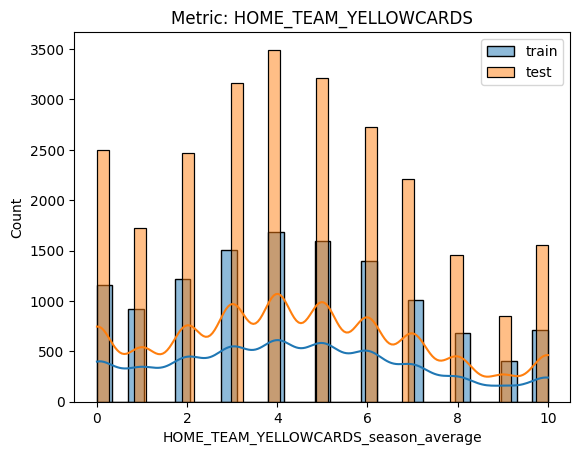

Metric: HOME_TEAM_YELLOWCARDS
Differences: {'l1_loss': {'loss_value': 0.0025210361998607117, 'estimated_typical_loss_value': 0.0022499245370302496, 'loss_value_normalized': 1.12049811376699}, 'l2_loss': {'loss_value': 9.314764635282175e-06, 'estimated_typical_loss_value': 9.662831085594873e-06, 'loss_value_normalized': 0.9639788331759588}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.02817042977003142, 'estimated_typical_loss_value': 0.026265091084168014, 'loss_value_normalized': 1.0725426262470363}}


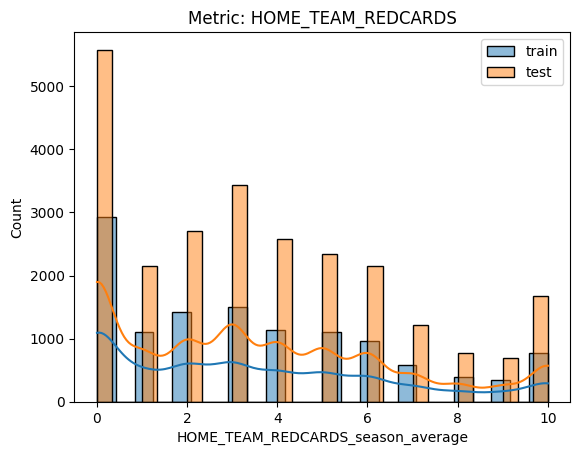

Metric: HOME_TEAM_REDCARDS
Differences: {'l1_loss': {'loss_value': 0.006431374523987115, 'estimated_typical_loss_value': 0.002091462314748187, 'loss_value_normalized': 3.0750611563186463}, 'l2_loss': {'loss_value': 9.196197265971058e-05, 'estimated_typical_loss_value': 9.878874266878977e-06, 'loss_value_normalized': 9.308952637039386}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.053734979486116434, 'estimated_typical_loss_value': 0.02978085017646243, 'loss_value_normalized': 1.8043467250839593}}


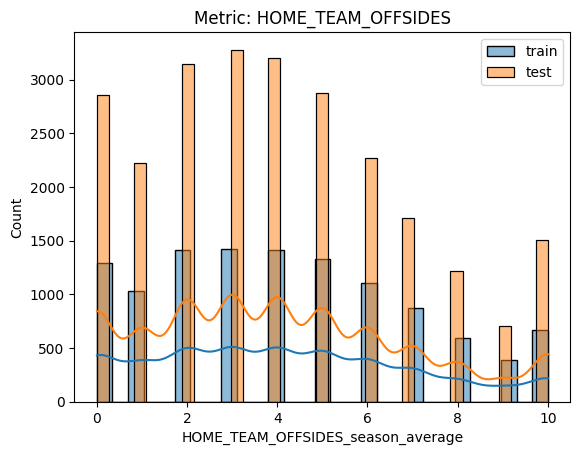

Metric: HOME_TEAM_OFFSIDES
Differences: {'l1_loss': {'loss_value': 0.0036781630621652195, 'estimated_typical_loss_value': 0.0022074904712599277, 'loss_value_normalized': 1.6662192249761032}, 'l2_loss': {'loss_value': 2.050306416887545e-05, 'estimated_typical_loss_value': 9.851702847548241e-06, 'loss_value_normalized': 2.0811695689254233}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0490813913533751, 'estimated_typical_loss_value': 0.02498956973498298, 'loss_value_normalized': 1.9640750870818502}}


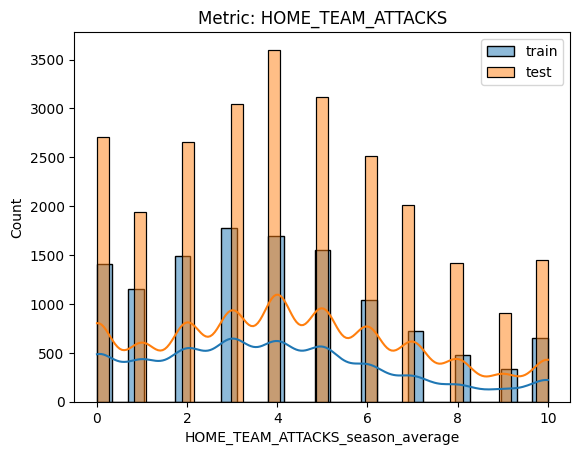

Metric: HOME_TEAM_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.011835368619209101, 'estimated_typical_loss_value': 0.0022689127741885025, 'loss_value_normalized': 5.216317151478409}, 'l2_loss': {'loss_value': 0.00020000753698500614, 'estimated_typical_loss_value': 9.727326560653256e-06, 'loss_value_normalized': 20.561408700872146}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.16265864300310823, 'estimated_typical_loss_value': 0.027275260711140514, 'loss_value_normalized': 5.963596268638759}}


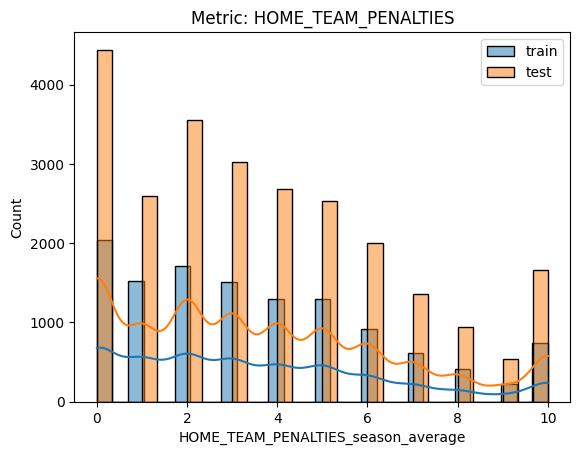

Metric: HOME_TEAM_PENALTIES
Differences: {'l1_loss': {'loss_value': 0.0038573662433935498, 'estimated_typical_loss_value': 0.002155908344545908, 'loss_value_normalized': 1.7892069730847564}, 'l2_loss': {'loss_value': 2.4864401706554713e-05, 'estimated_typical_loss_value': 9.676645101181487e-06, 'loss_value_normalized': 2.569527087745349}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.05548230661203044, 'estimated_typical_loss_value': 0.028621150245314305, 'loss_value_normalized': 1.9385072275742399}}


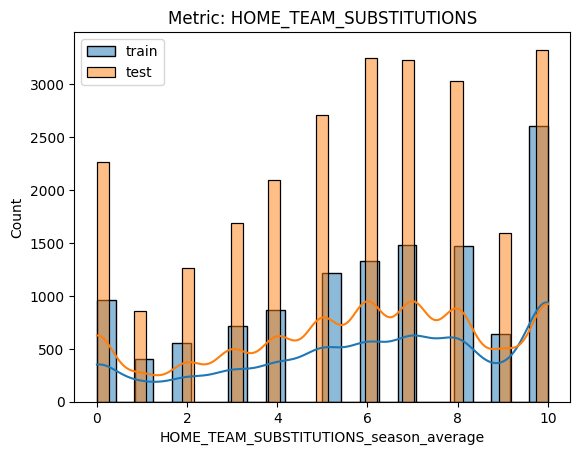

Metric: HOME_TEAM_SUBSTITUTIONS
Differences: {'l1_loss': {'loss_value': 0.014854861685547832, 'estimated_typical_loss_value': 0.0023012507513178486, 'loss_value_normalized': 6.4551251866140715}, 'l2_loss': {'loss_value': 0.0006796141535924116, 'estimated_typical_loss_value': 1.0556447335591131e-05, 'loss_value_normalized': 64.37905973222573}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.12939197966132673, 'estimated_typical_loss_value': 0.024669130146549395, 'loss_value_normalized': 5.245096965019025}}


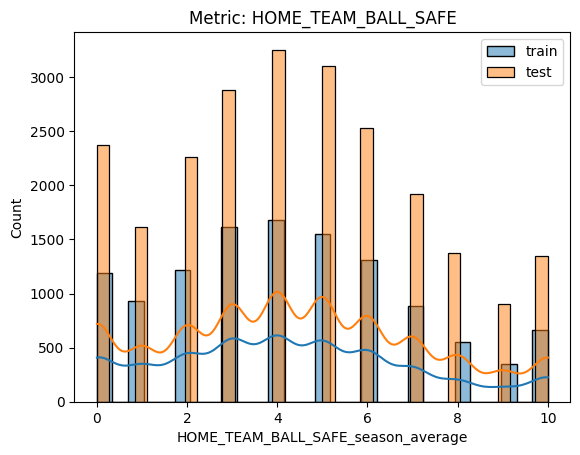

Metric: HOME_TEAM_BALL_SAFE
Differences: {'l1_loss': {'loss_value': 0.005457710481130873, 'estimated_typical_loss_value': 0.002375614571690961, 'loss_value_normalized': 2.2973888719858997}, 'l2_loss': {'loss_value': 3.9942849192668886e-05, 'estimated_typical_loss_value': 9.628097017467868e-06, 'loss_value_normalized': 4.148571531765937}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.08325299390124061, 'estimated_typical_loss_value': 0.026554337867498105, 'loss_value_normalized': 3.135193741853366}}


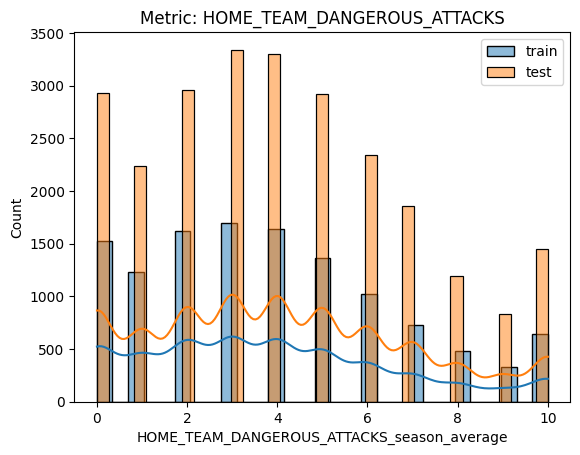

Metric: HOME_TEAM_DANGEROUS_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.008491486443883776, 'estimated_typical_loss_value': 0.0022508852878202305, 'loss_value_normalized': 3.7725096386880472}, 'l2_loss': {'loss_value': 0.00010763491000713352, 'estimated_typical_loss_value': 8.67015088623087e-06, 'loss_value_normalized': 12.414421780745796}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.10798646453572079, 'estimated_typical_loss_value': 0.0269366890320775, 'loss_value_normalized': 4.008898955885946}}


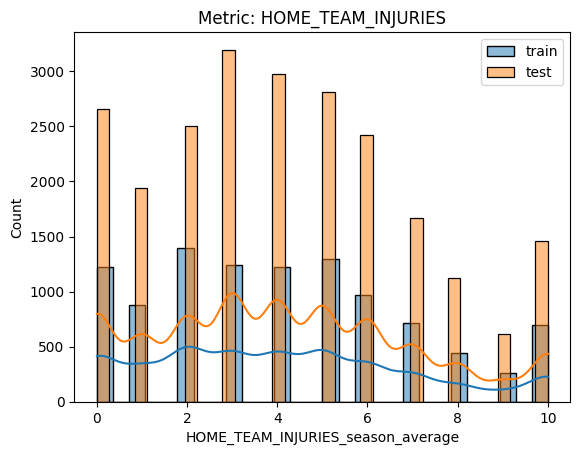

Metric: HOME_TEAM_INJURIES
Differences: {'l1_loss': {'loss_value': 0.0041329076153748985, 'estimated_typical_loss_value': 0.0022492739291016563, 'loss_value_normalized': 1.8374407678415337}, 'l2_loss': {'loss_value': 2.996912980455963e-05, 'estimated_typical_loss_value': 9.665737296830688e-06, 'loss_value_normalized': 3.1005528997459706}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.049665977488811304, 'estimated_typical_loss_value': 0.026926676329990927, 'loss_value_normalized': 1.8444897127349111}}


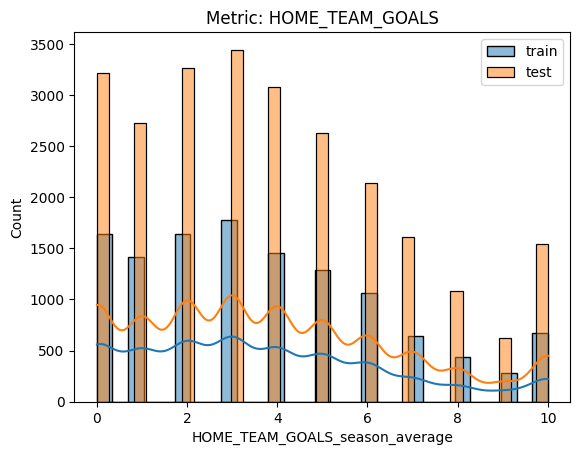

Metric: HOME_TEAM_GOALS
Differences: {'l1_loss': {'loss_value': 0.005412198145935726, 'estimated_typical_loss_value': 0.0022102614664758287, 'loss_value_normalized': 2.4486687335524655}, 'l2_loss': {'loss_value': 4.577680031263914e-05, 'estimated_typical_loss_value': 1.0037644165332887e-05, 'loss_value_normalized': 4.560512363023019}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.074296071644459, 'estimated_typical_loss_value': 0.02675026532457482, 'loss_value_normalized': 2.7773956909580404}}


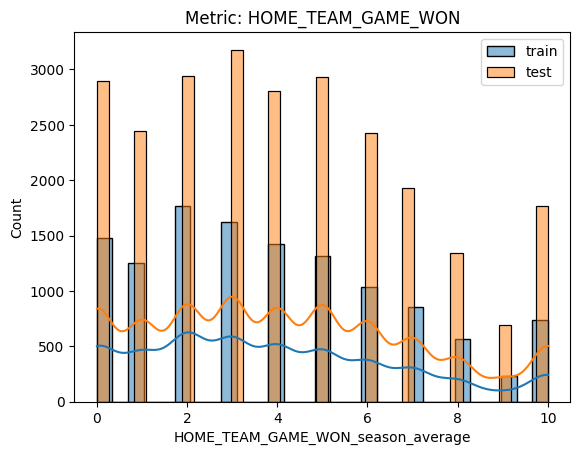

Metric: HOME_TEAM_GAME_WON
Differences: {'l1_loss': {'loss_value': 0.008392597448624155, 'estimated_typical_loss_value': 0.0021620194487012626, 'loss_value_normalized': 3.881832540250632}, 'l2_loss': {'loss_value': 0.00010072138443547102, 'estimated_typical_loss_value': 9.91079741227327e-06, 'loss_value_normalized': 10.162793188415264}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.11885366982035818, 'estimated_typical_loss_value': 0.02763426145630705, 'loss_value_normalized': 4.300953365744134}}


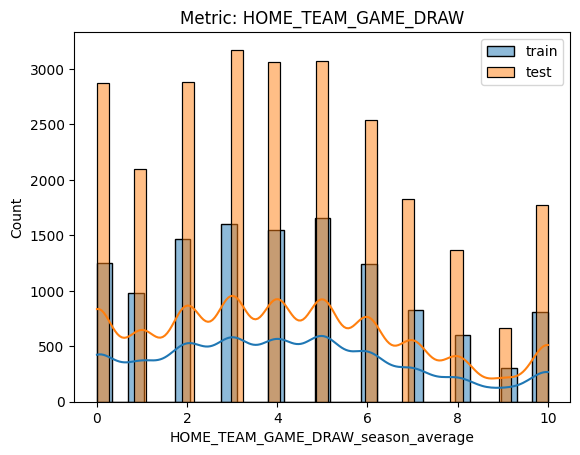

Metric: HOME_TEAM_GAME_DRAW
Differences: {'l1_loss': {'loss_value': 0.005534659969116976, 'estimated_typical_loss_value': 0.0022886861729713823, 'loss_value_normalized': 2.4182695008511526}, 'l2_loss': {'loss_value': 4.74682591997623e-05, 'estimated_typical_loss_value': 9.810384549826834e-06, 'loss_value_normalized': 4.838572734595383}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.05637828493715168, 'estimated_typical_loss_value': 0.026603782402819152, 'loss_value_normalized': 2.1191830576383346}}


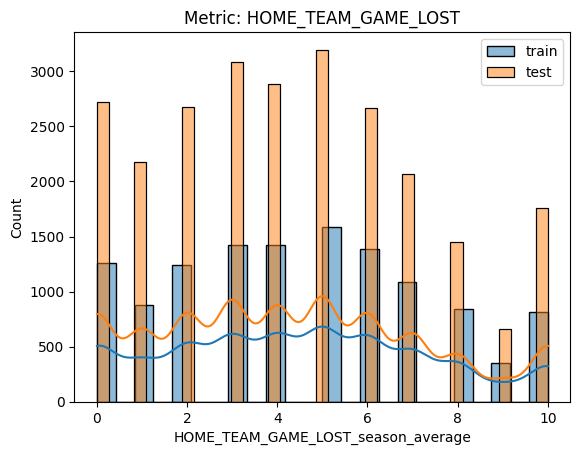

Metric: HOME_TEAM_GAME_LOST
Differences: {'l1_loss': {'loss_value': 0.005648397977628962, 'estimated_typical_loss_value': 0.002270587870708016, 'loss_value_normalized': 2.4876368144550702}, 'l2_loss': {'loss_value': 5.984064209323419e-05, 'estimated_typical_loss_value': 1.0236977948555713e-05, 'loss_value_normalized': 5.845537852348198}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.05779869282690438, 'estimated_typical_loss_value': 0.026897706609269108, 'loss_value_normalized': 2.1488334922571477}}


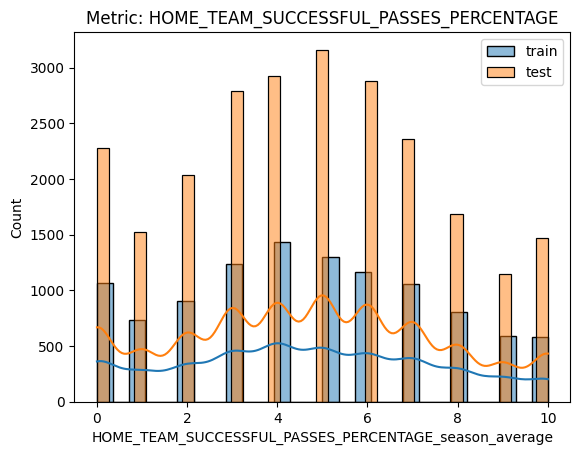

Metric: HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE
Differences: {'l1_loss': {'loss_value': 0.0038826670093659063, 'estimated_typical_loss_value': 0.00238695589807659, 'loss_value_normalized': 1.6266186620767478}, 'l2_loss': {'loss_value': 2.489576702264473e-05, 'estimated_typical_loss_value': 9.99652122484528e-06, 'loss_value_normalized': 2.4904430713572623}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04580613906617832, 'estimated_typical_loss_value': 0.024676516590199368, 'loss_value_normalized': 1.8562643920483686}}


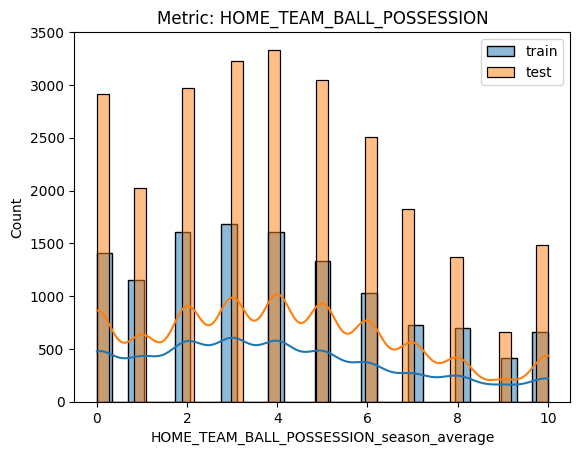

Metric: HOME_TEAM_BALL_POSSESSION
Differences: {'l1_loss': {'loss_value': 0.007277929110216119, 'estimated_typical_loss_value': 0.002364442839936623, 'loss_value_normalized': 3.078073610952894}, 'l2_loss': {'loss_value': 7.991726082187445e-05, 'estimated_typical_loss_value': 9.870316119530076e-06, 'loss_value_normalized': 8.09672758727017}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0886689720735714, 'estimated_typical_loss_value': 0.026345492814882646, 'loss_value_normalized': 3.3656220704089956}}
Missing season_average for AWAY_ID
Missing season_average for AWAY_LEAGUE
Missing season_average for AWAY_TEAM_NAME


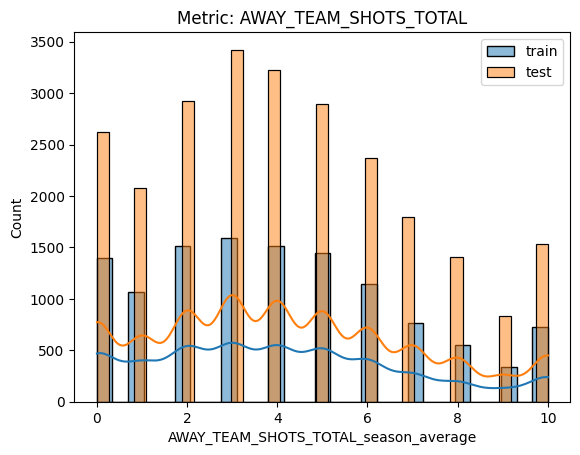

Metric: AWAY_TEAM_SHOTS_TOTAL
Differences: {'l1_loss': {'loss_value': 0.005795545407109995, 'estimated_typical_loss_value': 0.0023493275786085972, 'loss_value_normalized': 2.466895404404137}, 'l2_loss': {'loss_value': 5.7667602355515465e-05, 'estimated_typical_loss_value': 9.052701513168602e-06, 'loss_value_normalized': 6.3702091878556075}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.07524776553282782, 'estimated_typical_loss_value': 0.02641264885873553, 'loss_value_normalized': 2.84892916023984}}


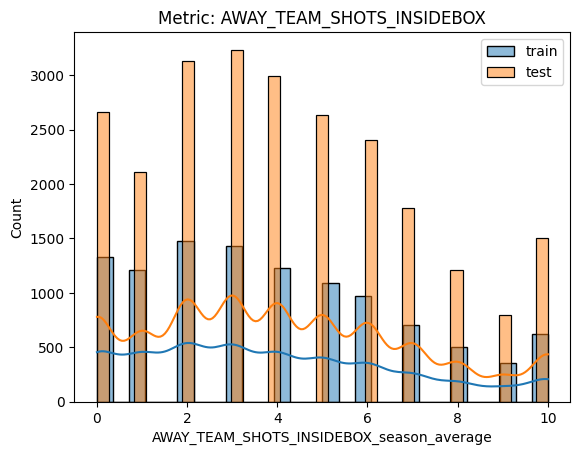

Metric: AWAY_TEAM_SHOTS_INSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.007829804403602574, 'estimated_typical_loss_value': 0.002236873125620176, 'loss_value_normalized': 3.500334602764282}, 'l2_loss': {'loss_value': 0.00015668414883448467, 'estimated_typical_loss_value': 1.0024240668742511e-05, 'loss_value_normalized': 15.630525444145109}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06928578828049622, 'estimated_typical_loss_value': 0.026201923684558627, 'loss_value_normalized': 2.6443015831439616}}


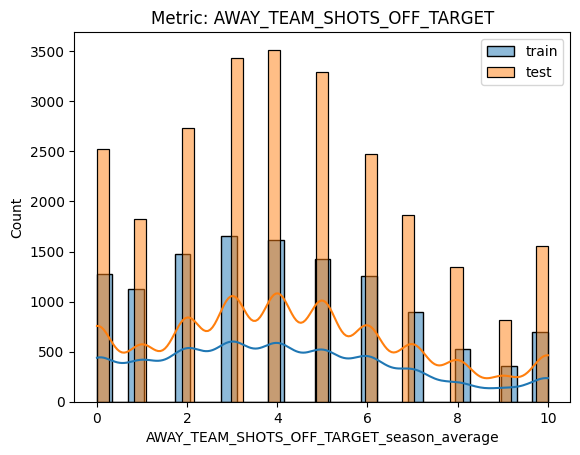

Metric: AWAY_TEAM_SHOTS_OFF_TARGET
Differences: {'l1_loss': {'loss_value': 0.006709016081502942, 'estimated_typical_loss_value': 0.0023067866248781574, 'loss_value_normalized': 2.9083817329037362}, 'l2_loss': {'loss_value': 8.44787210104444e-05, 'estimated_typical_loss_value': 9.491441365390986e-06, 'loss_value_normalized': 8.900515501945378}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.07601540952538692, 'estimated_typical_loss_value': 0.025312550516584507, 'loss_value_normalized': 3.0030719138943263}}


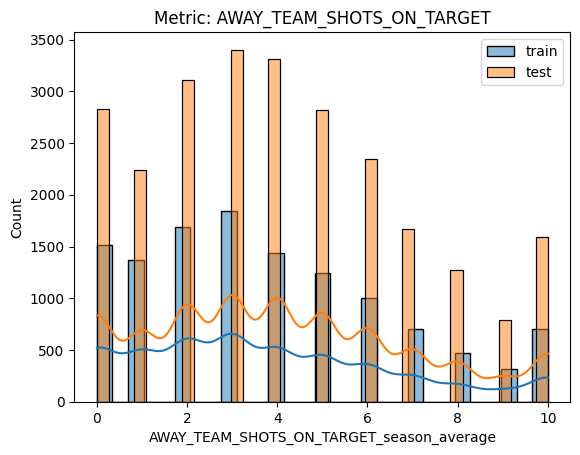

Metric: AWAY_TEAM_SHOTS_ON_TARGET
Differences: {'l1_loss': {'loss_value': 0.01037197494945109, 'estimated_typical_loss_value': 0.002250459815716069, 'loss_value_normalized': 4.608824773060802}, 'l2_loss': {'loss_value': 0.00018207101062701363, 'estimated_typical_loss_value': 9.615895529497692e-06, 'loss_value_normalized': 18.934379025259673}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.12215539647540599, 'estimated_typical_loss_value': 0.026833862054842676, 'loss_value_normalized': 4.552285326120611}}


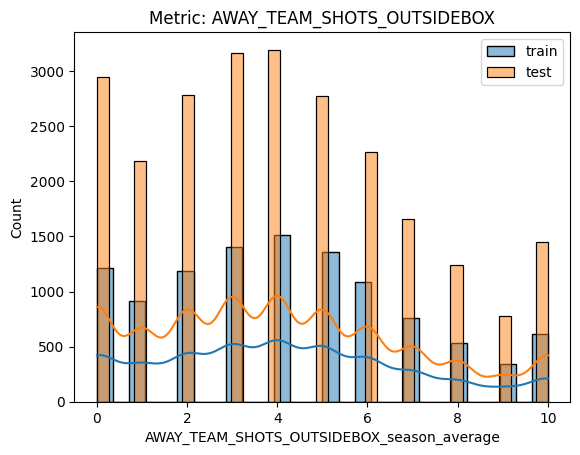

Metric: AWAY_TEAM_SHOTS_OUTSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.0048238596698776505, 'estimated_typical_loss_value': 0.002196304041537234, 'loss_value_normalized': 2.1963533184143547}, 'l2_loss': {'loss_value': 4.3972133134896105e-05, 'estimated_typical_loss_value': 9.125269799645287e-06, 'loss_value_normalized': 4.818721429533557}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.043939046576726024, 'estimated_typical_loss_value': 0.026518426630525494, 'loss_value_normalized': 1.6569250954785981}}


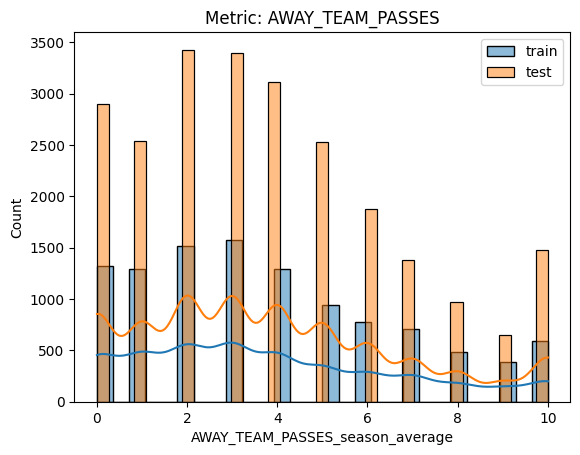

Metric: AWAY_TEAM_PASSES
Differences: {'l1_loss': {'loss_value': 0.006638850254473094, 'estimated_typical_loss_value': 0.0022100902814579495, 'loss_value_normalized': 3.0038819274355246}, 'l2_loss': {'loss_value': 7.597455564174103e-05, 'estimated_typical_loss_value': 9.690766593974398e-06, 'loss_value_normalized': 7.839891189541217}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.08400700324687728, 'estimated_typical_loss_value': 0.02720126690237858, 'loss_value_normalized': 3.088348919495757}}


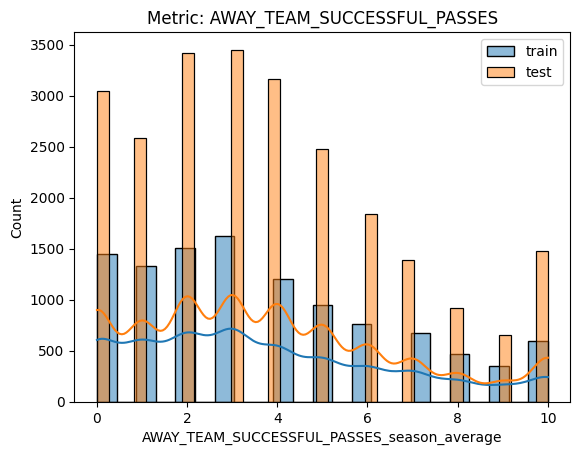

Metric: AWAY_TEAM_SUCCESSFUL_PASSES
Differences: {'l1_loss': {'loss_value': 0.007851997565182279, 'estimated_typical_loss_value': 0.002214162544961364, 'loss_value_normalized': 3.5462606767736222}, 'l2_loss': {'loss_value': 0.00011710134043679491, 'estimated_typical_loss_value': 8.7174523378328e-06, 'loss_value_normalized': 13.43297742226878}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.08424335751518841, 'estimated_typical_loss_value': 0.026584847863028015, 'loss_value_normalized': 3.168848584322588}}


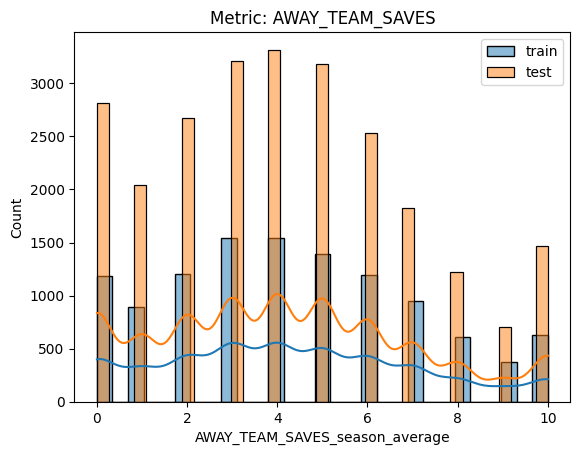

Metric: AWAY_TEAM_SAVES
Differences: {'l1_loss': {'loss_value': 0.004881243340492759, 'estimated_typical_loss_value': 0.002274404256738561, 'loss_value_normalized': 2.1461634738108804}, 'l2_loss': {'loss_value': 3.8905075132564166e-05, 'estimated_typical_loss_value': 9.429539305795657e-06, 'loss_value_normalized': 4.125872311464453}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.05651970243109114, 'estimated_typical_loss_value': 0.026318634316801082, 'loss_value_normalized': 2.1475165371711578}}


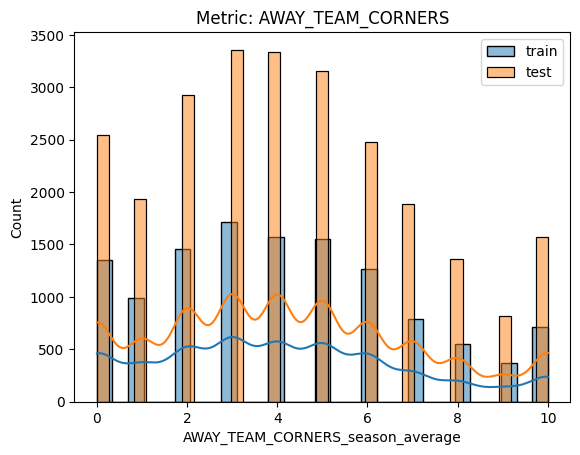

Metric: AWAY_TEAM_CORNERS
Differences: {'l1_loss': {'loss_value': 0.005523042103459916, 'estimated_typical_loss_value': 0.0023430229191624815, 'loss_value_normalized': 2.357229226521444}, 'l2_loss': {'loss_value': 4.65952277818124e-05, 'estimated_typical_loss_value': 9.362263150429317e-06, 'loss_value_normalized': 4.976919258947621}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06951988707219095, 'estimated_typical_loss_value': 0.02511819577134233, 'loss_value_normalized': 2.767710217128989}}


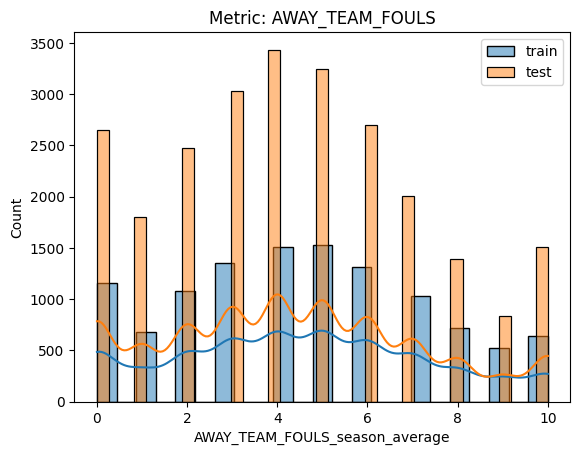

Metric: AWAY_TEAM_FOULS
Differences: {'l1_loss': {'loss_value': 0.005555049891740718, 'estimated_typical_loss_value': 0.002342101438687476, 'loss_value_normalized': 2.3718229278972927}, 'l2_loss': {'loss_value': 5.878704039473035e-05, 'estimated_typical_loss_value': 9.2088243275529e-06, 'loss_value_normalized': 6.383772597053613}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06252974900039655, 'estimated_typical_loss_value': 0.024431884916861307, 'loss_value_normalized': 2.559350177572341}}


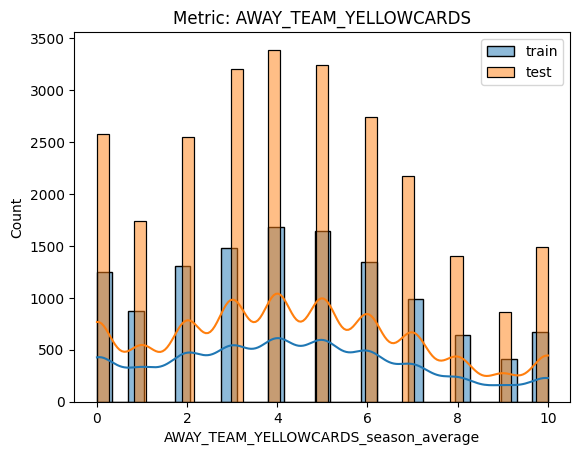

Metric: AWAY_TEAM_YELLOWCARDS
Differences: {'l1_loss': {'loss_value': 0.003379090506544913, 'estimated_typical_loss_value': 0.0022554094308358725, 'loss_value_normalized': 1.4982160047509703}, 'l2_loss': {'loss_value': 1.5249885805101845e-05, 'estimated_typical_loss_value': 9.318251376813745e-06, 'loss_value_normalized': 1.6365608941055372}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03705195407524491, 'estimated_typical_loss_value': 0.025339859345587076, 'loss_value_normalized': 1.4622004633067218}}


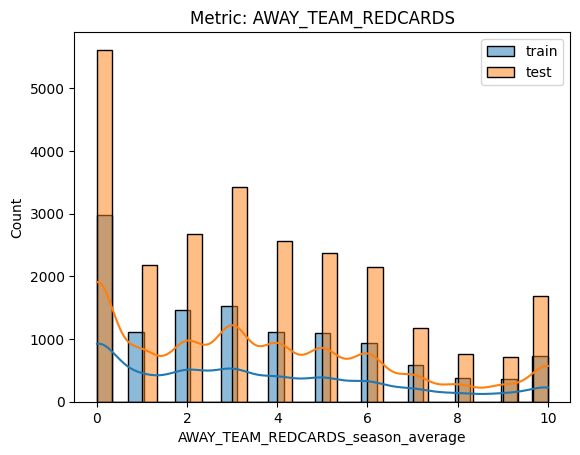

Metric: AWAY_TEAM_REDCARDS
Differences: {'l1_loss': {'loss_value': 0.007585461719958472, 'estimated_typical_loss_value': 0.0022755655360528018, 'loss_value_normalized': 3.3334402370654117}, 'l2_loss': {'loss_value': 0.00010798248509490755, 'estimated_typical_loss_value': 9.261332734739602e-06, 'loss_value_normalized': 11.659497416313778}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06986247194221734, 'estimated_typical_loss_value': 0.028736861278824685, 'loss_value_normalized': 2.4311100389274705}}


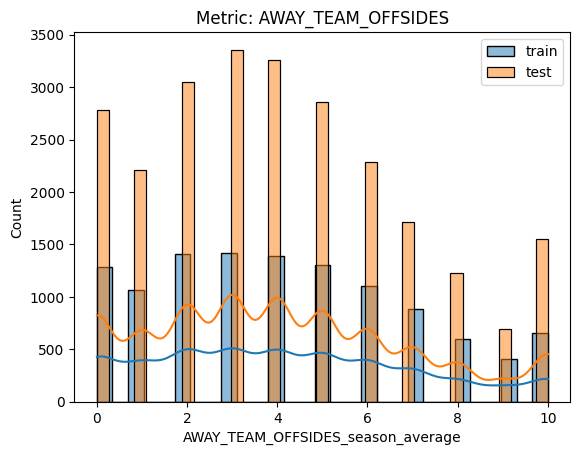

Metric: AWAY_TEAM_OFFSIDES
Differences: {'l1_loss': {'loss_value': 0.004894484670211671, 'estimated_typical_loss_value': 0.0022691672709960926, 'loss_value_normalized': 2.156951906001477}, 'l2_loss': {'loss_value': 3.477027568476449e-05, 'estimated_typical_loss_value': 9.839364926888668e-06, 'loss_value_normalized': 3.533792672834082}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06394122517775293, 'estimated_typical_loss_value': 0.026048808387618128, 'loss_value_normalized': 2.45466987304286}}


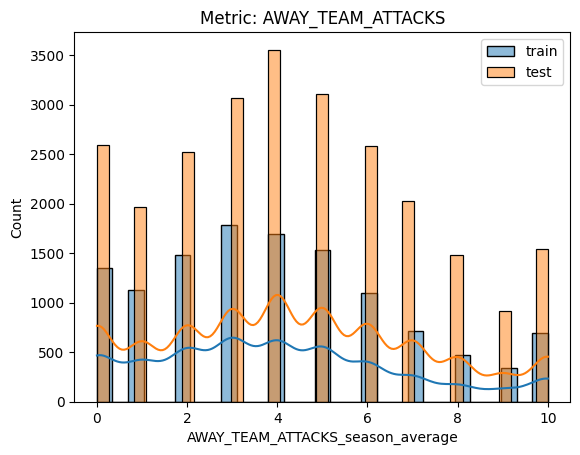

Metric: AWAY_TEAM_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.011791421519060237, 'estimated_typical_loss_value': 0.002203418854397214, 'loss_value_normalized': 5.351420813853756}, 'l2_loss': {'loss_value': 0.00019803115639650484, 'estimated_typical_loss_value': 9.07577766191298e-06, 'loss_value_normalized': 21.819745234913473}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.16602937907400345, 'estimated_typical_loss_value': 0.027450700618367838, 'loss_value_normalized': 6.048274737399904}}


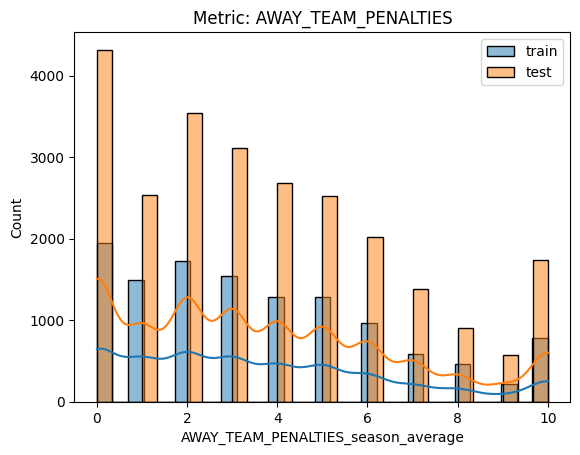

Metric: AWAY_TEAM_PENALTIES
Differences: {'l1_loss': {'loss_value': 0.0035274019868102957, 'estimated_typical_loss_value': 0.002163126165521801, 'loss_value_normalized': 1.6306963703890265}, 'l2_loss': {'loss_value': 2.0332831874748263e-05, 'estimated_typical_loss_value': 8.497861440446923e-06, 'loss_value_normalized': 2.392699859454007}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06196641718406792, 'estimated_typical_loss_value': 0.02880206923733971, 'loss_value_normalized': 2.151457128772285}}


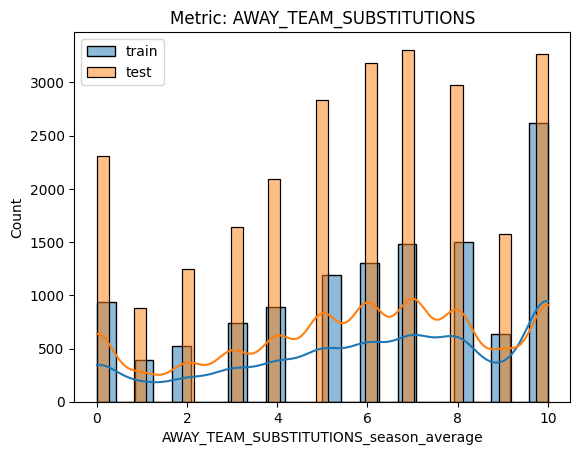

Metric: AWAY_TEAM_SUBSTITUTIONS
Differences: {'l1_loss': {'loss_value': 0.015221397947663513, 'estimated_typical_loss_value': 0.002310721835506616, 'loss_value_normalized': 6.587291344968324}, 'l2_loss': {'loss_value': 0.000722168138966736, 'estimated_typical_loss_value': 8.646525418744621e-06, 'loss_value_normalized': 83.52119539053426}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.12967773734559648, 'estimated_typical_loss_value': 0.025372478631566695, 'loss_value_normalized': 5.110960550155286}}


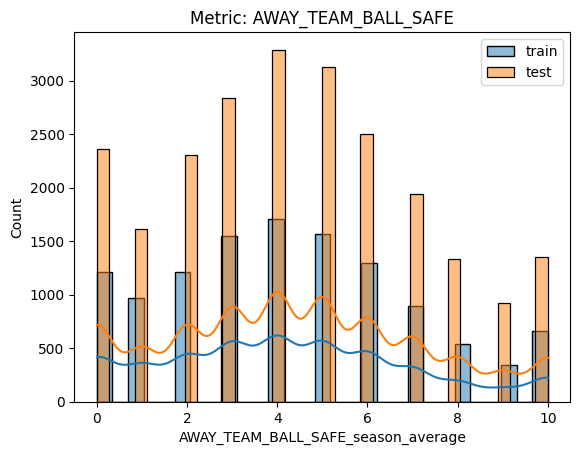

Metric: AWAY_TEAM_BALL_SAFE
Differences: {'l1_loss': {'loss_value': 0.005980688974082266, 'estimated_typical_loss_value': 0.0022182182055278748, 'loss_value_normalized': 2.696168014119435}, 'l2_loss': {'loss_value': 5.566081824447014e-05, 'estimated_typical_loss_value': 9.592733653315353e-06, 'loss_value_normalized': 5.802393796678047}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.08977848953975402, 'estimated_typical_loss_value': 0.026068464647020374, 'loss_value_normalized': 3.4439500275676935}}


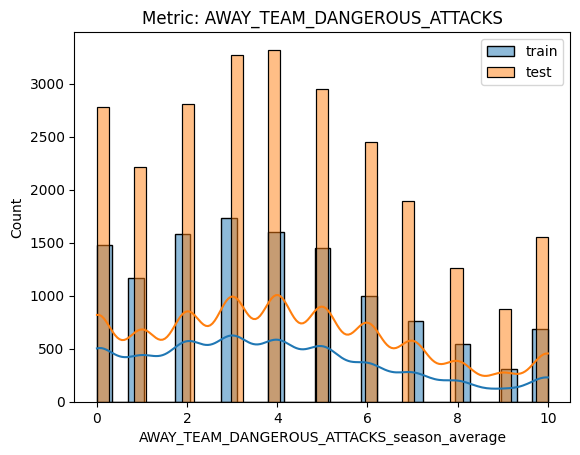

Metric: AWAY_TEAM_DANGEROUS_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.008864844550616553, 'estimated_typical_loss_value': 0.0022175760039283886, 'loss_value_normalized': 3.99753809335589}, 'l2_loss': {'loss_value': 0.00010761224375997703, 'estimated_typical_loss_value': 9.693220242359218e-06, 'loss_value_normalized': 11.101805289355559}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.1202014102358936, 'estimated_typical_loss_value': 0.02684420117731353, 'loss_value_normalized': 4.477742118006356}}


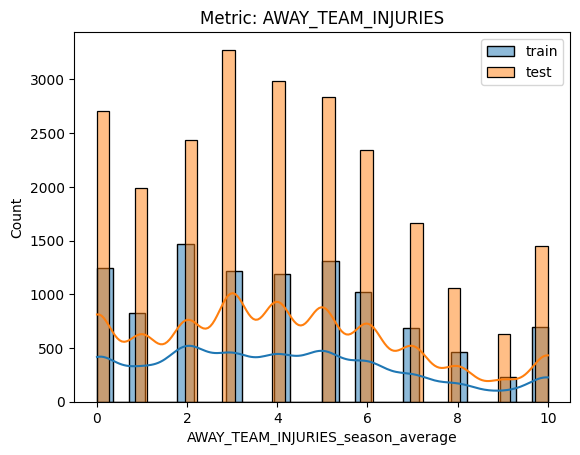

Metric: AWAY_TEAM_INJURIES
Differences: {'l1_loss': {'loss_value': 0.0030450137321680767, 'estimated_typical_loss_value': 0.0021839280550772344, 'loss_value_normalized': 1.3942829870648283}, 'l2_loss': {'loss_value': 1.7703110887343652e-05, 'estimated_typical_loss_value': 9.751230617457323e-06, 'loss_value_normalized': 1.8154745366443503}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04645208809172375, 'estimated_typical_loss_value': 0.02601228670867335, 'loss_value_normalized': 1.785774876771395}}


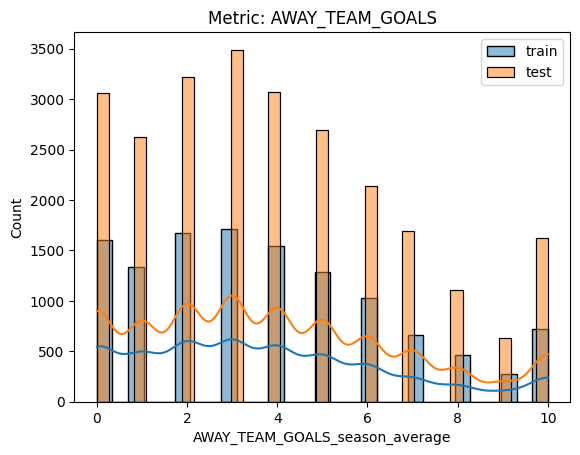

Metric: AWAY_TEAM_GOALS
Differences: {'l1_loss': {'loss_value': 0.005413993507202472, 'estimated_typical_loss_value': 0.002294591051173601, 'loss_value_normalized': 2.3594590000832105}, 'l2_loss': {'loss_value': 4.975020893386434e-05, 'estimated_typical_loss_value': 1.0141073783122546e-05, 'loss_value_normalized': 4.905812737066627}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.07577704136146178, 'estimated_typical_loss_value': 0.0272850385776619, 'loss_value_normalized': 2.777237831120363}}


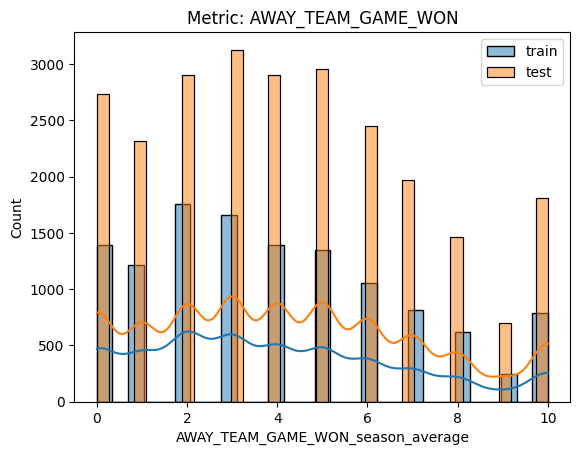

Metric: AWAY_TEAM_GAME_WON
Differences: {'l1_loss': {'loss_value': 0.009283127567790322, 'estimated_typical_loss_value': 0.0023072139844740936, 'loss_value_normalized': 4.023522581892387}, 'l2_loss': {'loss_value': 0.00012221243343183712, 'estimated_typical_loss_value': 9.638205909940149e-06, 'loss_value_normalized': 12.67999818337358}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.12185572443072212, 'estimated_typical_loss_value': 0.026121753867861003, 'loss_value_normalized': 4.664913583028846}}


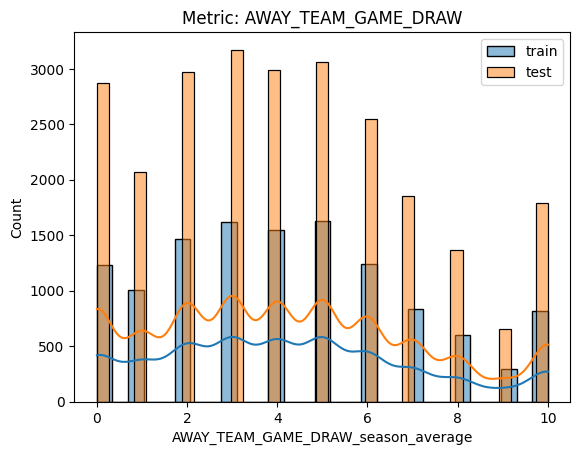

Metric: AWAY_TEAM_GAME_DRAW
Differences: {'l1_loss': {'loss_value': 0.005121699059458043, 'estimated_typical_loss_value': 0.0023076087673601447, 'loss_value_normalized': 2.219483272858538}, 'l2_loss': {'loss_value': 4.275923218550639e-05, 'estimated_typical_loss_value': 9.30365899164145e-06, 'loss_value_normalized': 4.595958667756571}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.05260599195048409, 'estimated_typical_loss_value': 0.026103011556833346, 'loss_value_normalized': 2.015322708490785}}


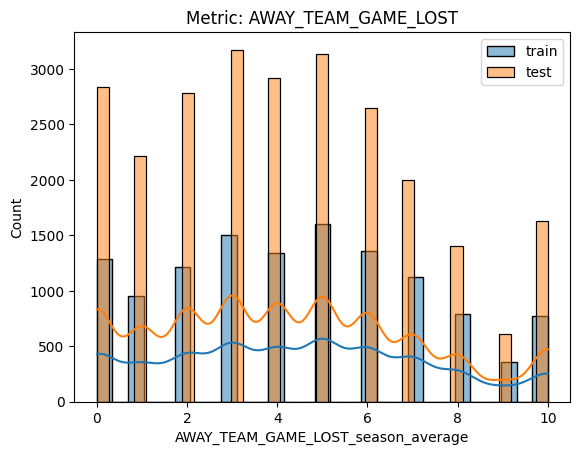

Metric: AWAY_TEAM_GAME_LOST
Differences: {'l1_loss': {'loss_value': 0.005422874064501212, 'estimated_typical_loss_value': 0.0023805212988032226, 'loss_value_normalized': 2.2780195527874456}, 'l2_loss': {'loss_value': 5.687532434424674e-05, 'estimated_typical_loss_value': 9.974684725583709e-06, 'loss_value_normalized': 5.701967120534966}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06108439056020964, 'estimated_typical_loss_value': 0.02533768003717746, 'loss_value_normalized': 2.4108122949923287}}


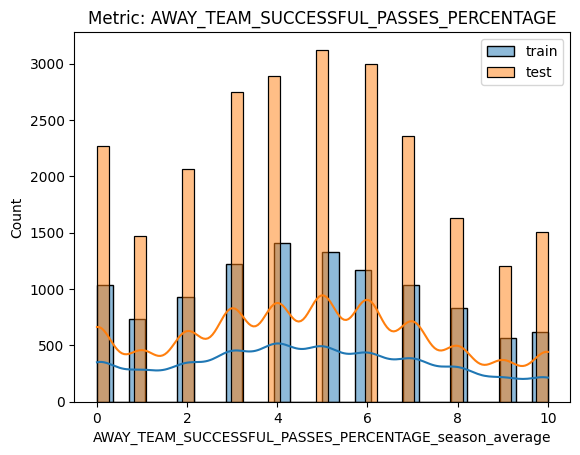

Metric: AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE
Differences: {'l1_loss': {'loss_value': 0.003677133113862224, 'estimated_typical_loss_value': 0.002389453608951034, 'loss_value_normalized': 1.5389012367041257}, 'l2_loss': {'loss_value': 2.367762091734085e-05, 'estimated_typical_loss_value': 9.796890861122682e-06, 'loss_value_normalized': 2.416850534771686}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04070917626825971, 'estimated_typical_loss_value': 0.024950667155725803, 'loss_value_normalized': 1.631586683200862}}


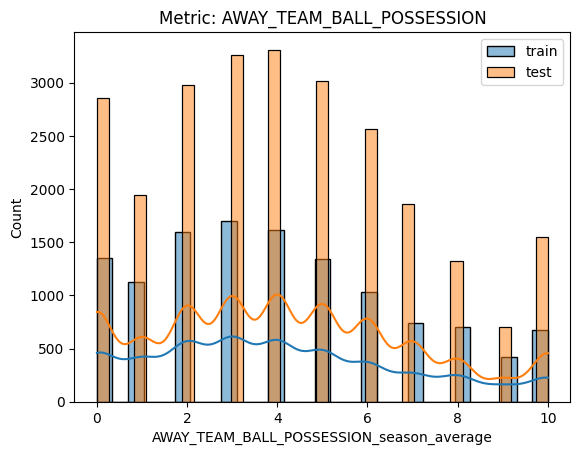

Metric: AWAY_TEAM_BALL_POSSESSION
Differences: {'l1_loss': {'loss_value': 0.007772388703029673, 'estimated_typical_loss_value': 0.0021869874695223377, 'loss_value_normalized': 3.553924661820975}, 'l2_loss': {'loss_value': 8.646526991707726e-05, 'estimated_typical_loss_value': 1.0149489662896233e-05, 'loss_value_normalized': 8.519174144418225}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.09360525358321482, 'estimated_typical_loss_value': 0.026574440313356217, 'loss_value_normalized': 3.5223791161527633}}


In [21]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference

column_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures_train)
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    # Compute the distribution difference
    column_name = f"{metric_name}_season_average"
    loss_name_to_loss_values = compute_distribution_difference(
        feature_serie1=df_teamfeatures_train[column_name],
        feature_serie2=df_teamfeatures_test[column_name],
        n_monte_carlo=50,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    sns.histplot(df_teamfeatures_train[column_name], kde=True, label="train")
    sns.histplot(df_teamfeatures_test[column_name], kde=True, label="test")
    plt.legend()
    plt.show()
    print(f"Metric: {metric_name}")
    print(f"Differences: {loss_name_to_loss_values}")   

## Player features

In [23]:
from src.data_loading import load_dataframe_playersfeatures
df_playersfeatures_train, _ = load_dataframe_playersfeatures('train')   # we only take the HOME players features
df_playersfeatures_test, _ = load_dataframe_playersfeatures('test')

We plot the top playermetrics season averaged distributions for train in test, in terms of difference between the two distributions.

Some of them are top because for some reason the train data is totally incomplete (NaN in the data, and so we assign a uniform distribution).

Missing season_average for ID
Missing season_average for LEAGUE
Missing season_average for TEAM_NAME
Missing season_average for POSITION
Missing season_average for PLAYER_NAME
PLAYER_SHOTS_OFF_TARGET_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014962383607579238, 'estimated_typical_loss_value': 0.002390980392156863, 'loss_value_normalized': 6.257844546387323}


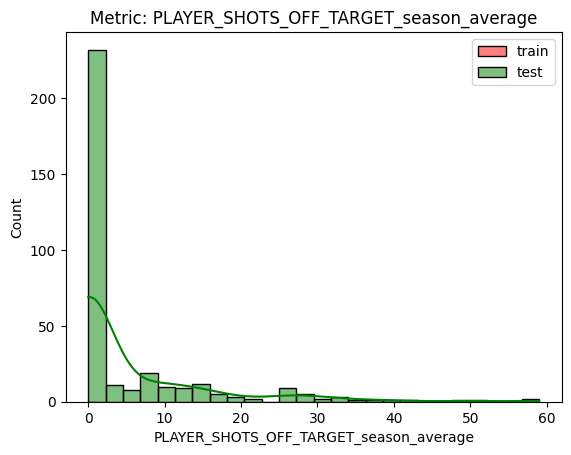

PLAYER_LONG_BALLS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014422081629960249, 'estimated_typical_loss_value': 0.002497058823529412, 'loss_value_normalized': 5.775627507875203}


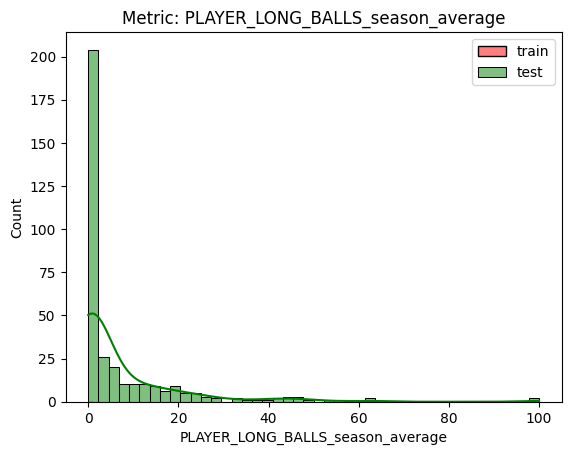

PLAYER_LONG_BALLS_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.013939791022569831, 'estimated_typical_loss_value': 0.002510392156862745, 'loss_value_normalized': 5.552834040076533}


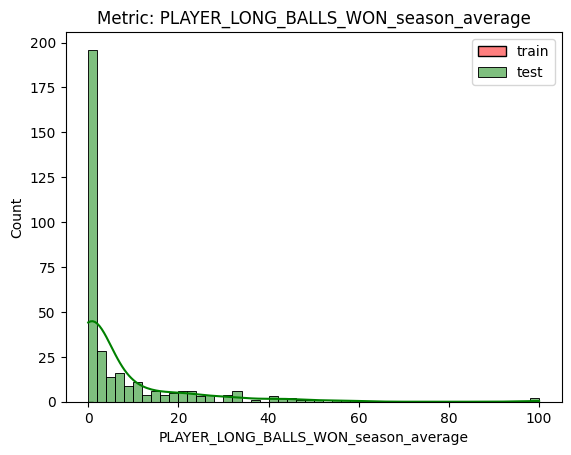

PLAYER_PUNCHES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0006750744116112795, 'estimated_typical_loss_value': 0.00039078431372548995, 'loss_value_normalized': 1.7274859504343056}


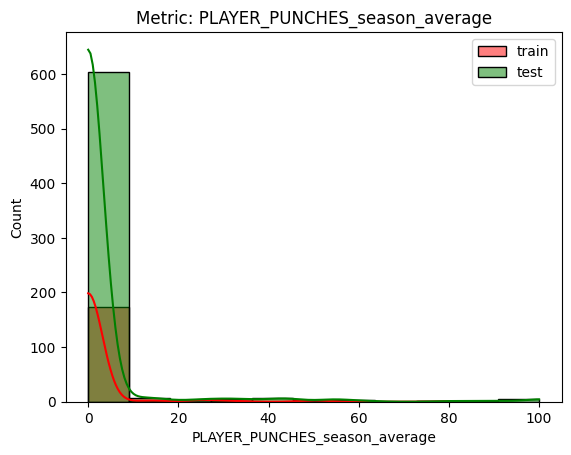

PLAYER_GOALS_CONCEDED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0029010434583190002, 'estimated_typical_loss_value': 0.0024303921568627454, 'loss_value_normalized': 1.1936524112485314}


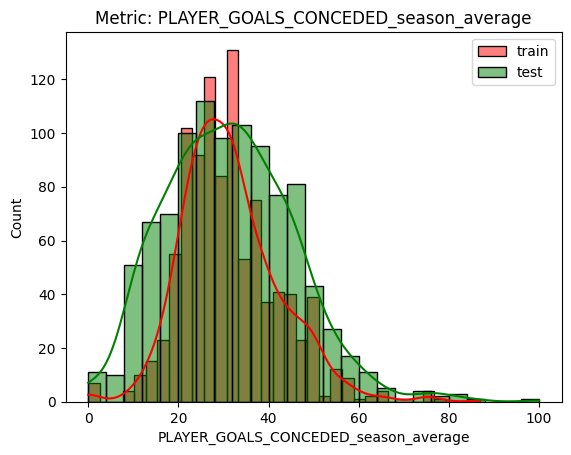

PLAYER_DRIBBLED_ATTEMPTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0020720856421286363, 'estimated_typical_loss_value': 0.0021611764705882362, 'loss_value_normalized': 0.9587766988618177}


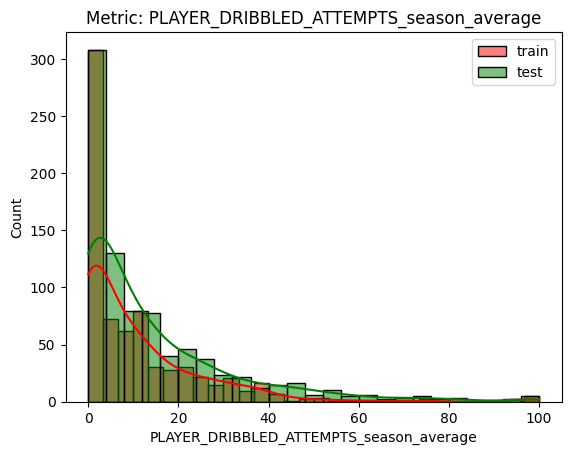

PLAYER_YELLOWCARDS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.001822543927807086, 'estimated_typical_loss_value': 0.00210764705882353, 'loss_value_normalized': 0.8647291870699746}


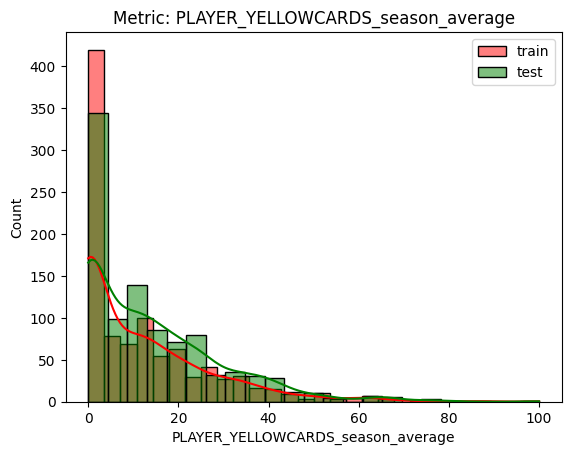

PLAYER_SUCCESSFUL_DRIBBLES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0015082515139860685, 'estimated_typical_loss_value': 0.002051568627450981, 'loss_value_normalized': 0.7351699055078003}


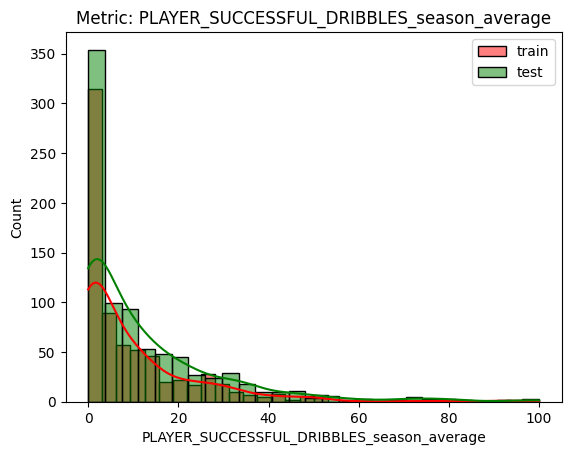

PLAYER_ERROR_LEAD_TO_GOAL_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0004023473399441983, 'estimated_typical_loss_value': 0.0005476470588235292, 'loss_value_normalized': 0.7346836497366918}


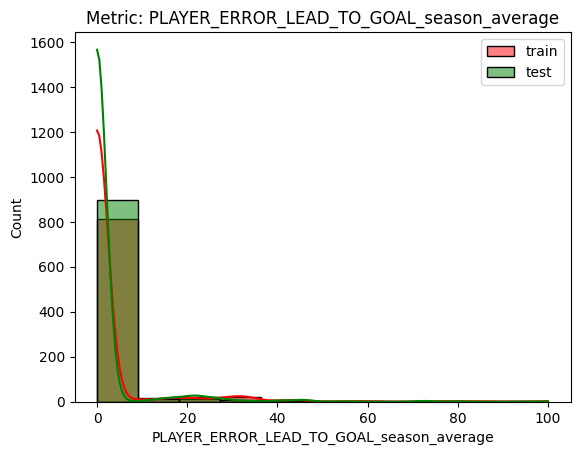

PLAYER_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0013659240326989585, 'estimated_typical_loss_value': 0.0020472549019607844, 'loss_value_normalized': 0.6671978322731474}


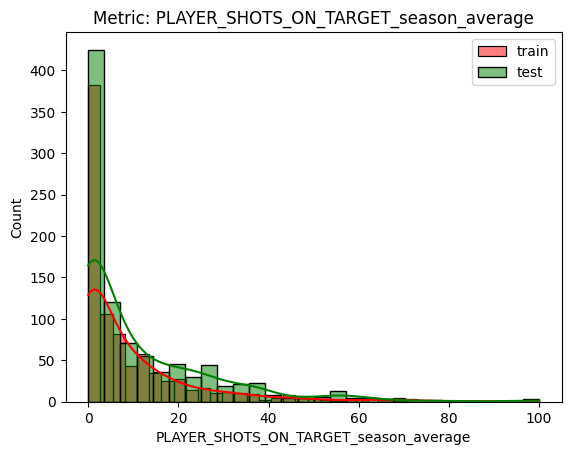

In [24]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_playersfeatures_train)
metric_names_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    # Compute the distribution difference
    column_name = f"{metric_name}_season_average"
    metric_names_to_loss_name_to_loss_values[column_name] = compute_distribution_difference(
        feature_serie1=df_playersfeatures_train[column_name],
        feature_serie2=df_playersfeatures_test[column_name],
        n_monte_carlo=50,
        n_value_max=101,
        )
    
# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_NAME} normalized): {loss_name_to_loss_values[LOSS_NAME]}")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {column_name}")
    sns.histplot(df_playersfeatures_train[column_name], kde=True, label="train", color='red')
    sns.histplot(df_playersfeatures_test[column_name], kde=True, label="test", color='green')
    plt.legend()
    plt.show()

We plot here the distribution of those differences.

As we can see, if LOSS_STATISTIC = 'loss_value_normalized', a lot of metrics have a normalized difference equal or even inferor to 1, which means that the train and test distributions are not notably different.

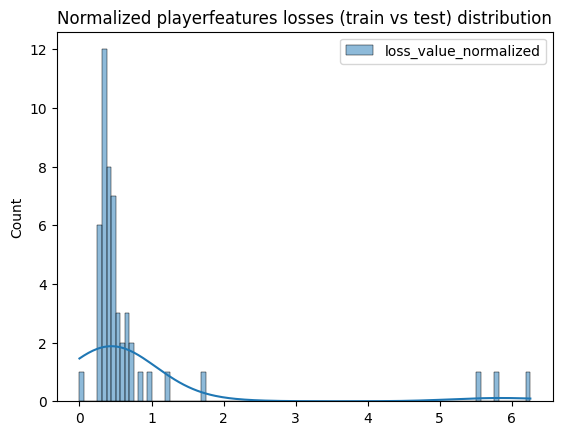

In [25]:
LOSS_NAME = 'l1_loss'
LOSS_STATISTIC = 'loss_value_normalized'

loss_value_normalized_values = list(metric_names_to_loss_name_to_loss_values.values())
loss_value_normalized_values = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values]
fig, ax = plt.subplots()
ax.set_title(f"Normalized playerfeatures losses (train vs test) distribution")
sns.histplot(loss_value_normalized_values, kde=True, label="loss_value_normalized", bins=100)
plt.legend()

Below we plot every player feature distribution in train and test.

Missing season_average for ID
Missing season_average for LEAGUE
Missing season_average for TEAM_NAME
Missing season_average for POSITION
Missing season_average for PLAYER_NAME


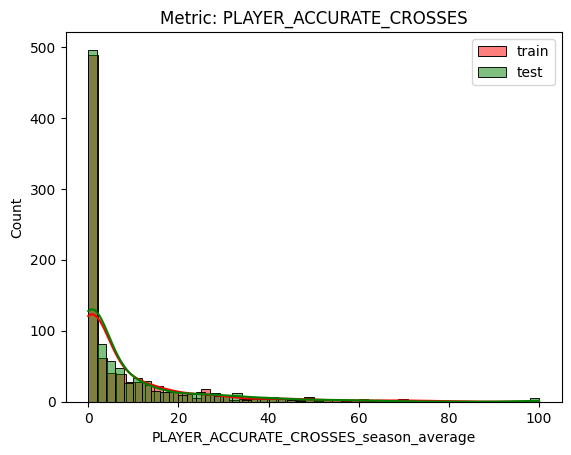

Metric: PLAYER_ACCURATE_CROSSES
Differences: {'l1_loss': {'loss_value': 0.0010382284102502543, 'estimated_typical_loss_value': 0.0018049019607843141, 'loss_value_normalized': 0.575227038813215}, 'l2_loss': {'loss_value': 7.825733127339901e-06, 'estimated_typical_loss_value': 1.566490196078432e-05, 'loss_value_normalized': 0.4995711525562047}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.14421160463400537, 'estimated_typical_loss_value': 395610320208.55963, 'loss_value_normalized': 3.645294302686018e-13}}


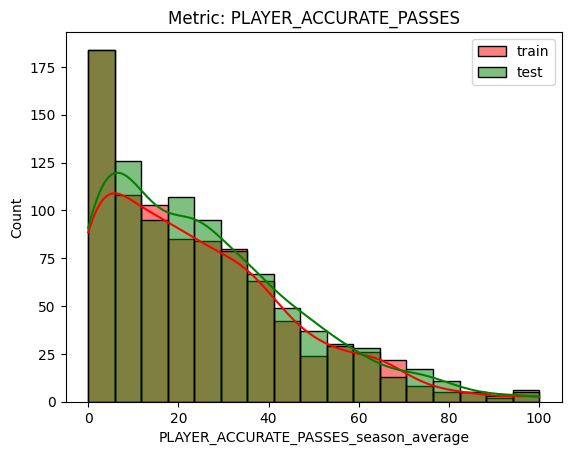

Metric: PLAYER_ACCURATE_PASSES
Differences: {'l1_loss': {'loss_value': 0.0009659536862815695, 'estimated_typical_loss_value': 0.0028874509803921583, 'loss_value_normalized': 0.3345350943932924}, 'l2_loss': {'loss_value': 7.936518262731652e-06, 'estimated_typical_loss_value': 1.912294117647058e-05, 'loss_value_normalized': 0.41502602499268354}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 278860658041.6117, 'estimated_typical_loss_value': 350132794559.6958, 'loss_value_normalized': 0.7964425565799648}}


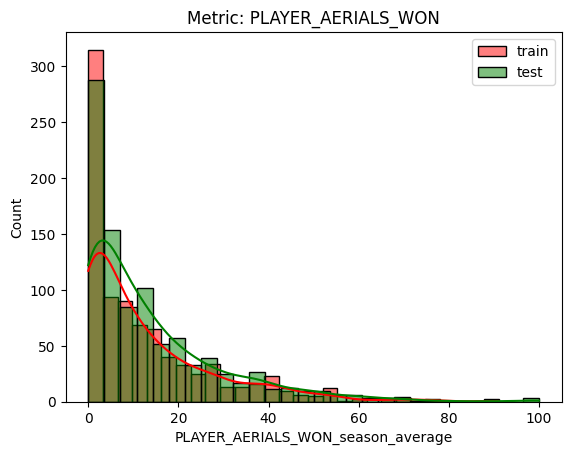

Metric: PLAYER_AERIALS_WON
Differences: {'l1_loss': {'loss_value': 0.0012221041570321938, 'estimated_typical_loss_value': 0.0022649019607843134, 'loss_value_normalized': 0.5395836897985956}, 'l2_loss': {'loss_value': 1.2333529958591864e-05, 'estimated_typical_loss_value': 1.8999215686274514e-05, 'loss_value_normalized': 0.64915995281625}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.13676163640796685, 'estimated_typical_loss_value': 289643270152.76245, 'loss_value_normalized': 4.721726706642851e-13}}


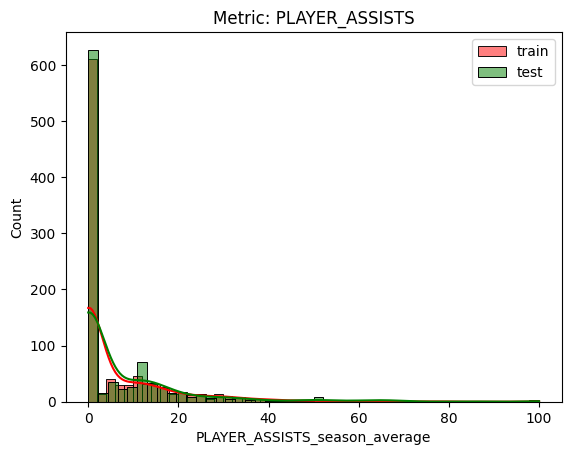

Metric: PLAYER_ASSISTS
Differences: {'l1_loss': {'loss_value': 0.0006034786220544729, 'estimated_typical_loss_value': 0.001570980392156863, 'loss_value_normalized': 0.3841414094455038}, 'l2_loss': {'loss_value': 2.4927522978057407e-06, 'estimated_typical_loss_value': 1.0570588235294122e-05, 'loss_value_normalized': 0.23581963862998004}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 222994633955.8265, 'estimated_typical_loss_value': 366027852067.9546, 'loss_value_normalized': 0.6092285947530207}}


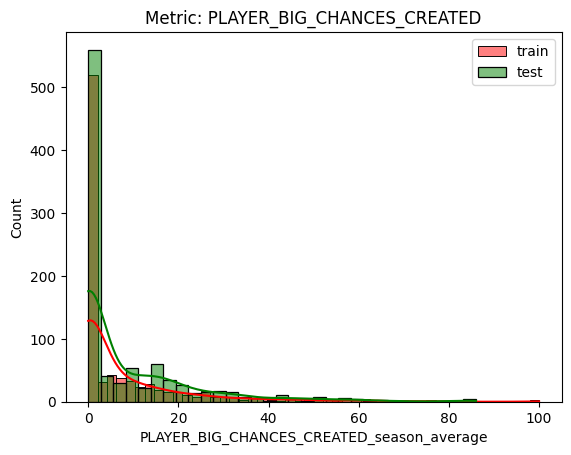

Metric: PLAYER_BIG_CHANCES_CREATED
Differences: {'l1_loss': {'loss_value': 0.0006220662663433005, 'estimated_typical_loss_value': 0.0016880392156862745, 'loss_value_normalized': 0.36851410829950226}, 'l2_loss': {'loss_value': 2.1380306817839797e-06, 'estimated_typical_loss_value': 1.3728235294117638e-05, 'loss_value_normalized': 0.1557396588813943}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 185907105361.10864, 'estimated_typical_loss_value': 349691265184.37006, 'loss_value_normalized': 0.5316321105792894}}


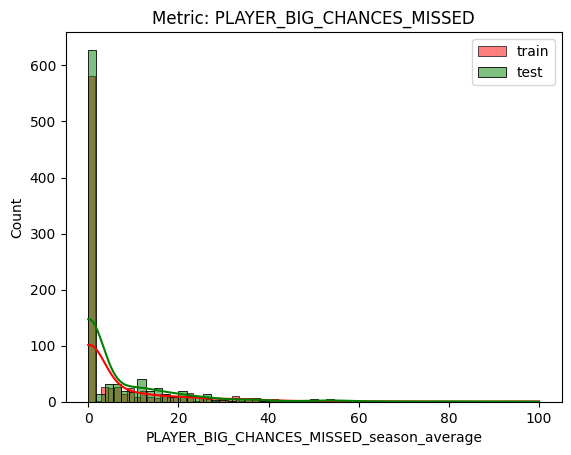

Metric: PLAYER_BIG_CHANCES_MISSED
Differences: {'l1_loss': {'loss_value': 0.00039594593163437227, 'estimated_typical_loss_value': 0.0015082352941176475, 'loss_value_normalized': 0.2625226535796933}, 'l2_loss': {'loss_value': 9.751444045763245e-07, 'estimated_typical_loss_value': 1.0608627450980396e-05, 'loss_value_normalized': 0.09191994054478708}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.062141569909633834, 'estimated_typical_loss_value': 358521852688.99493, 'loss_value_normalized': 1.733271471280147e-13}}


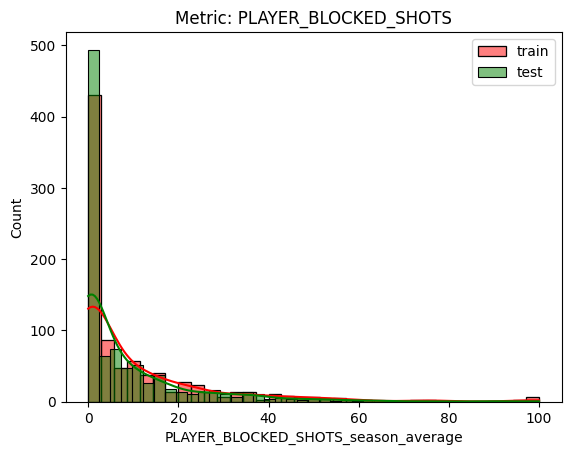

Metric: PLAYER_BLOCKED_SHOTS
Differences: {'l1_loss': {'loss_value': 0.0009763089056062925, 'estimated_typical_loss_value': 0.0019070588235294117, 'loss_value_normalized': 0.511944830206818}, 'l2_loss': {'loss_value': 1.334530953969625e-05, 'estimated_typical_loss_value': 1.573823529411765e-05, 'loss_value_normalized': 0.8479546334204275}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.15960555438312815, 'estimated_typical_loss_value': 395168790833.3197, 'loss_value_normalized': 4.038921040463669e-13}}


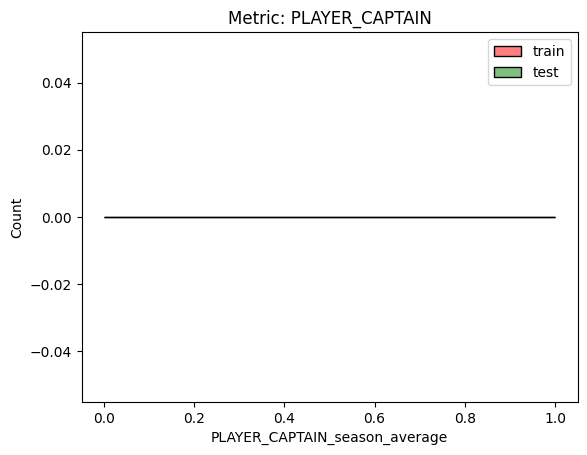

Metric: PLAYER_CAPTAIN
Differences: {'l1_loss': {'loss_value': 0.0, 'estimated_typical_loss_value': 0.0034968627450980396, 'loss_value_normalized': 0.0}, 'l2_loss': {'loss_value': 0.0, 'estimated_typical_loss_value': 1.9738235294117645e-05, 'loss_value_normalized': 0.0}, 'kl_divergence': {'loss_value': 0.0, 'estimated_typical_loss_value': inf, 'loss_value_normalized': 0.0}, 'sum_ratio_abs_diff': {'loss_value': 0.0, 'estimated_typical_loss_value': 0.41893070078673955, 'loss_value_normalized': 0.0}}


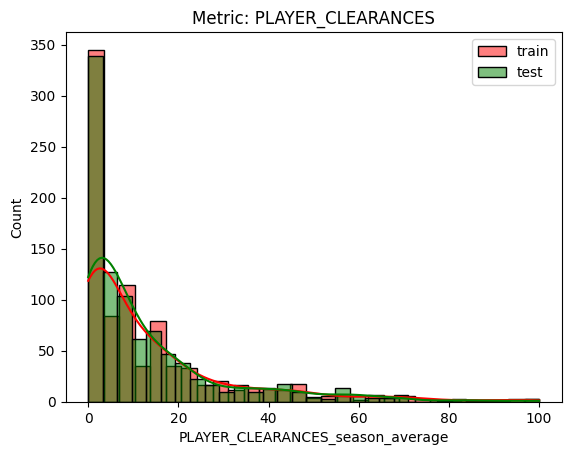

Metric: PLAYER_CLEARANCES
Differences: {'l1_loss': {'loss_value': 0.0013560395051617235, 'estimated_typical_loss_value': 0.002308235294117647, 'loss_value_normalized': 0.5874788885766331}, 'l2_loss': {'loss_value': 1.2461068337541023e-05, 'estimated_typical_loss_value': 1.691686274509804e-05, 'loss_value_normalized': 0.7366063391977498}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.13885467693342102, 'estimated_typical_loss_value': 443295492733.7168, 'loss_value_normalized': 3.132327740964189e-13}}


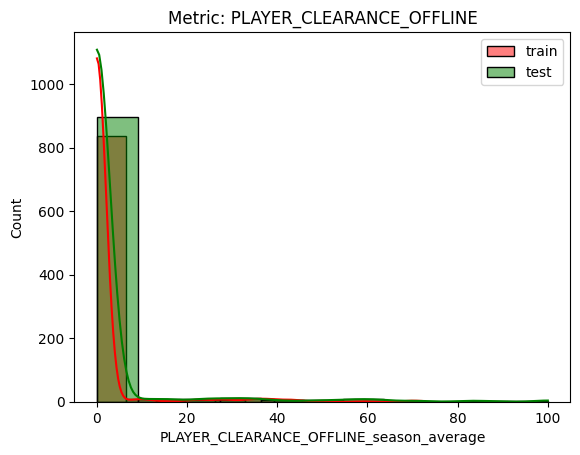

Metric: PLAYER_CLEARANCE_OFFLINE
Differences: {'l1_loss': {'loss_value': 0.0003285193330768087, 'estimated_typical_loss_value': 0.0005129411764705882, 'loss_value_normalized': 0.6404620025577215}, 'l2_loss': {'loss_value': 1.4091629658544803e-06, 'estimated_typical_loss_value': 2.005686274509798e-06, 'loss_value_normalized': 0.7025839402739511}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 697151645103.8257, 'estimated_typical_loss_value': 464930432119.9031, 'loss_value_normalized': 1.4994751836851885}}


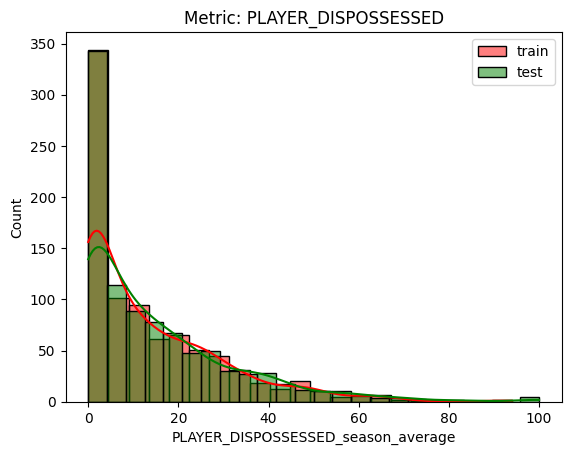

Metric: PLAYER_DISPOSSESSED
Differences: {'l1_loss': {'loss_value': 0.0009947600236757967, 'estimated_typical_loss_value': 0.002286666666666666, 'loss_value_normalized': 0.4350262494208602}, 'l2_loss': {'loss_value': 5.568235401132725e-06, 'estimated_typical_loss_value': 1.7393137254901957e-05, 'loss_value_normalized': 0.32013979533751613}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 139430329020.87155, 'estimated_typical_loss_value': 388104320829.6019, 'loss_value_normalized': 0.35925992455541034}}


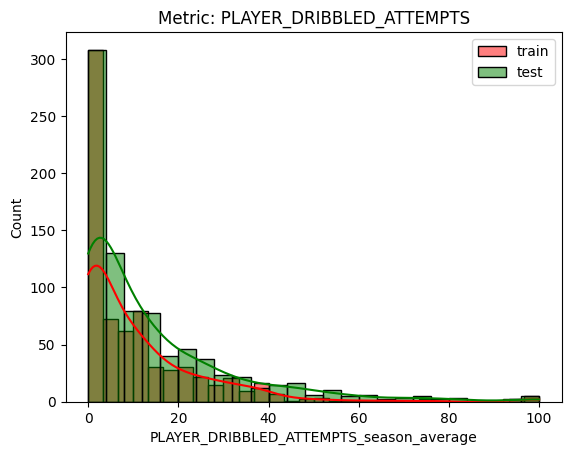

Metric: PLAYER_DRIBBLED_ATTEMPTS
Differences: {'l1_loss': {'loss_value': 0.0020720856421286363, 'estimated_typical_loss_value': 0.0021778431372549024, 'loss_value_normalized': 0.9514393422935955}, 'l2_loss': {'loss_value': 4.0764783088785106e-05, 'estimated_typical_loss_value': 1.694431372549019e-05, 'loss_value_normalized': 2.405809037100534}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 980030155305.7875, 'estimated_typical_loss_value': 341743736430.17816, 'loss_value_normalized': 2.867734067471396}}


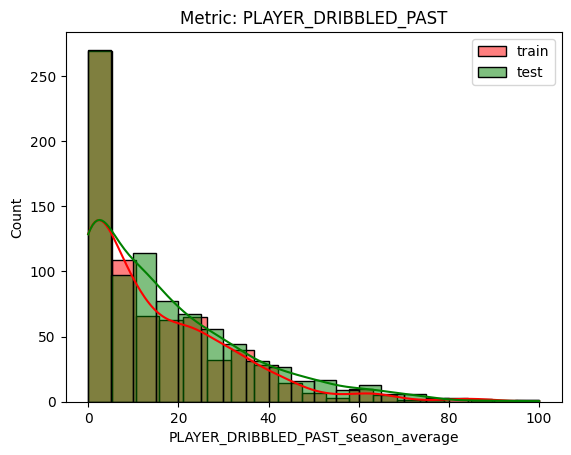

Metric: PLAYER_DRIBBLED_PAST
Differences: {'l1_loss': {'loss_value': 0.001160164064325898, 'estimated_typical_loss_value': 0.0024013725490196077, 'loss_value_normalized': 0.48312539626533296}, 'l2_loss': {'loss_value': 1.513313653527916e-05, 'estimated_typical_loss_value': 1.8450980392156866e-05, 'loss_value_normalized': 0.820180619861795}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 257902672448.9895, 'estimated_typical_loss_value': 305979857036.3823, 'loss_value_normalized': 0.8428746746499844}}


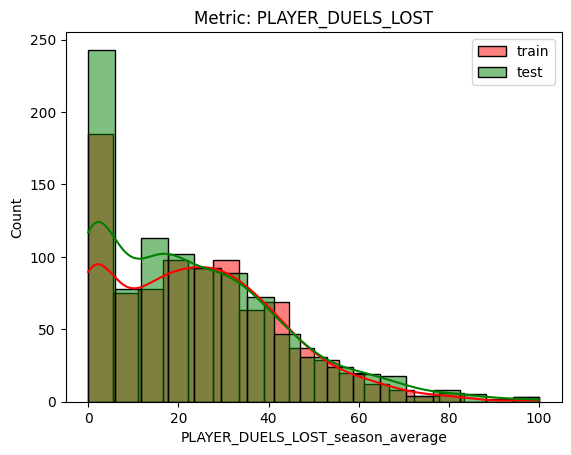

Metric: PLAYER_DUELS_LOST
Differences: {'l1_loss': {'loss_value': 0.0008831590008625426, 'estimated_typical_loss_value': 0.0026833333333333336, 'loss_value_normalized': 0.3291275779611687}, 'l2_loss': {'loss_value': 4.210130107594686e-06, 'estimated_typical_loss_value': 1.8884117647058823e-05, 'loss_value_normalized': 0.22294555595510732}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 139430329020.86078, 'estimated_typical_loss_value': 314368915165.8186, 'loss_value_normalized': 0.4435245416911407}}


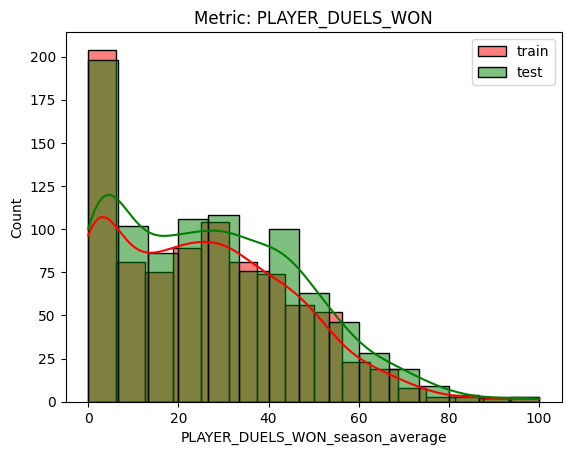

Metric: PLAYER_DUELS_WON
Differences: {'l1_loss': {'loss_value': 0.0009089764454062247, 'estimated_typical_loss_value': 0.0028235294117647065, 'loss_value_normalized': 0.32192915774801256}, 'l2_loss': {'loss_value': 8.922282822014964e-06, 'estimated_typical_loss_value': 1.9774705882352946e-05, 'loss_value_normalized': 0.4511967396631204}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 139430329020.8897, 'estimated_typical_loss_value': 307745974537.33936, 'loss_value_normalized': 0.4530695461752413}}


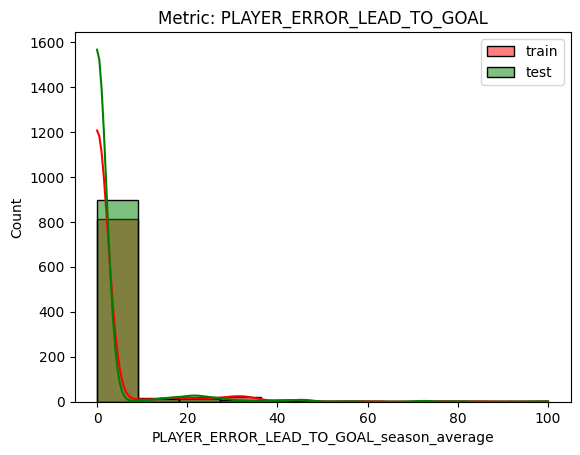

Metric: PLAYER_ERROR_LEAD_TO_GOAL
Differences: {'l1_loss': {'loss_value': 0.0004023473399441983, 'estimated_typical_loss_value': 0.0005701960784313724, 'loss_value_normalized': 0.7056297915112147}, 'l2_loss': {'loss_value': 3.7183784006443624e-06, 'estimated_typical_loss_value': 2.3952941176470543e-06, 'loss_value_normalized': 1.5523681926594908}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.1314047779810845, 'estimated_typical_loss_value': 370884675195.3939, 'loss_value_normalized': 3.543009101464121e-13}}


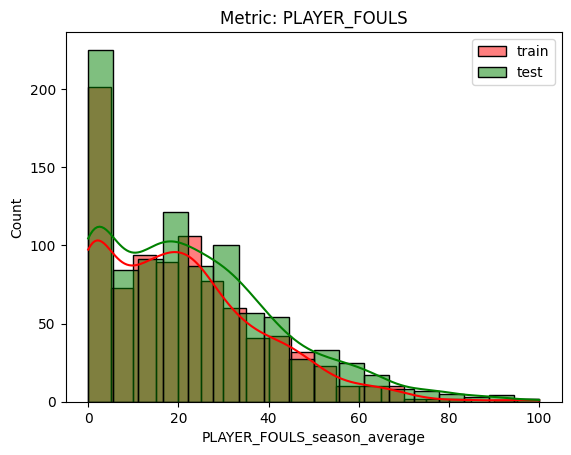

Metric: PLAYER_FOULS
Differences: {'l1_loss': {'loss_value': 0.0010531964090923535, 'estimated_typical_loss_value': 0.002620980392156863, 'loss_value_normalized': 0.40183299815744344}, 'l2_loss': {'loss_value': 5.930939764085776e-06, 'estimated_typical_loss_value': 1.779352941176471e-05, 'loss_value_normalized': 0.3333200303752189}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 464767763402.7028, 'estimated_typical_loss_value': 315251973916.2831, 'loss_value_normalized': 1.474273920093279}}


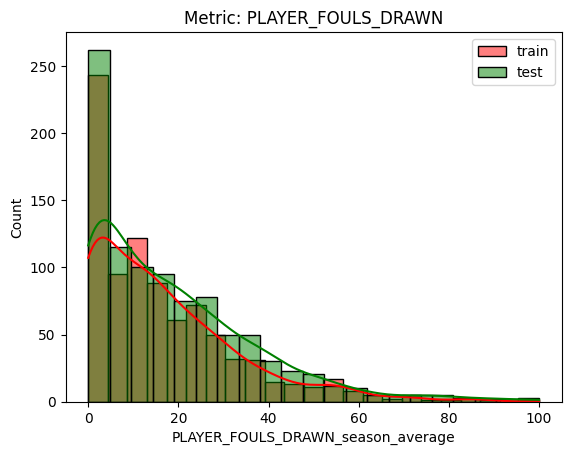

Metric: PLAYER_FOULS_DRAWN
Differences: {'l1_loss': {'loss_value': 0.0010462537052269147, 'estimated_typical_loss_value': 0.002513529411764706, 'loss_value_normalized': 0.41624884130250356}, 'l2_loss': {'loss_value': 6.701960707748275e-06, 'estimated_typical_loss_value': 1.9405098039215684e-05, 'loss_value_normalized': 0.3453711336128074}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 418290987062.38855, 'estimated_typical_loss_value': 371767733946.02783, 'loss_value_normalized': 1.1251406425795811}}


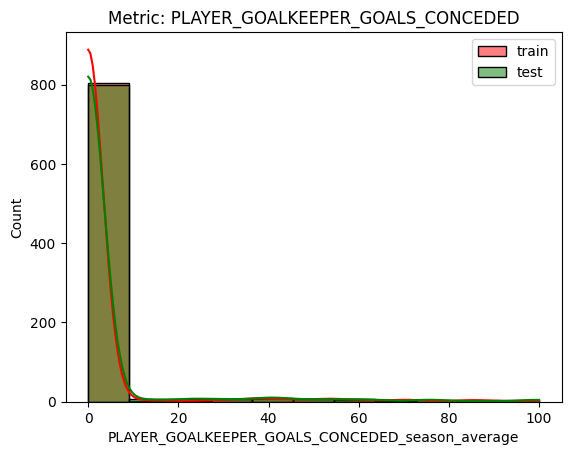

Metric: PLAYER_GOALKEEPER_GOALS_CONCEDED
Differences: {'l1_loss': {'loss_value': 0.00027271532841667757, 'estimated_typical_loss_value': 0.0005719607843137252, 'loss_value_normalized': 0.47680773908965246}, 'l2_loss': {'loss_value': 1.9392470145991416e-06, 'estimated_typical_loss_value': 2.216078431372545e-06, 'loss_value_normalized': 0.8750804966788777}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 257902672448.89163, 'estimated_typical_loss_value': 550587130915.0201, 'loss_value_normalized': 0.4684139130173338}}


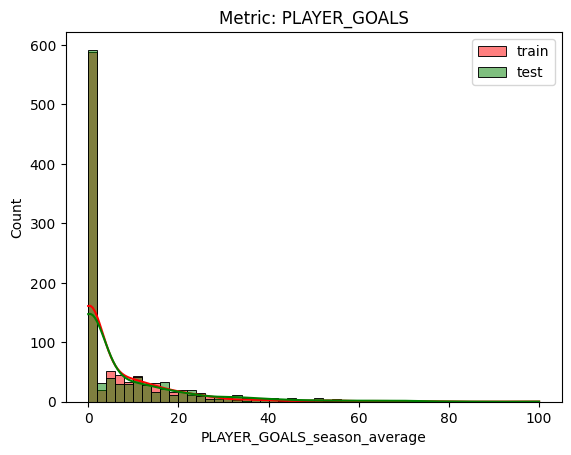

Metric: PLAYER_GOALS
Differences: {'l1_loss': {'loss_value': 0.0006270532586322056, 'estimated_typical_loss_value': 0.001613333333333334, 'loss_value_normalized': 0.3886693751851978}, 'l2_loss': {'loss_value': 1.0602903965402985e-06, 'estimated_typical_loss_value': 1.2284313725490202e-05, 'loss_value_normalized': 0.08631254624513611}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 312192487538.17993, 'estimated_typical_loss_value': 476410195876.062, 'loss_value_normalized': 0.6553018601209717}}


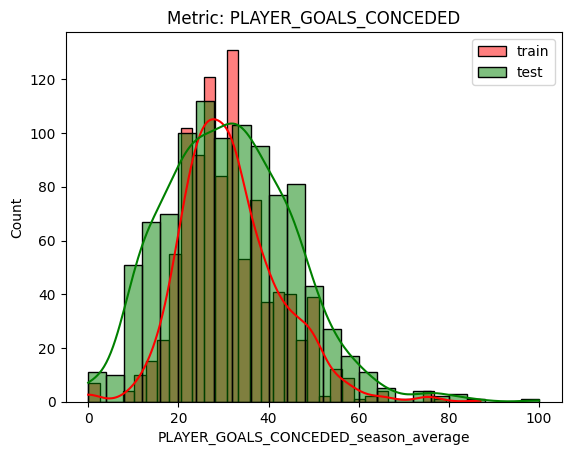

Metric: PLAYER_GOALS_CONCEDED
Differences: {'l1_loss': {'loss_value': 0.0029010434583190002, 'estimated_typical_loss_value': 0.002437843137254902, 'loss_value_normalized': 1.1900041532554937}, 'l2_loss': {'loss_value': 1.7463710717617024e-05, 'estimated_typical_loss_value': 1.922745098039216e-05, 'loss_value_normalized': 0.9082696783481363}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 1025775316196.9032, 'estimated_typical_loss_value': 178377867594.1366, 'loss_value_normalized': 5.750575057500133}}


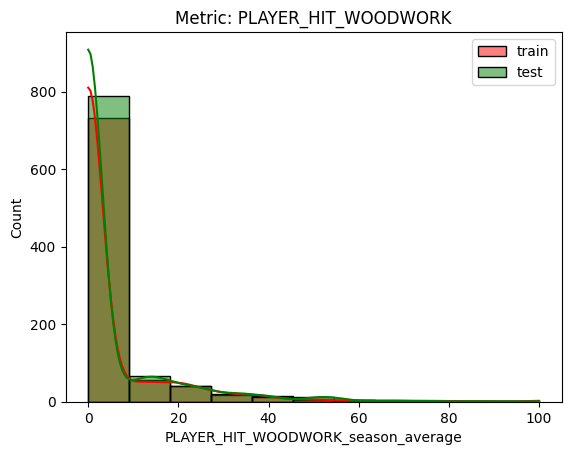

Metric: PLAYER_HIT_WOODWORK
Differences: {'l1_loss': {'loss_value': 0.00037643575704301963, 'estimated_typical_loss_value': 0.0011192156862745099, 'loss_value_normalized': 0.3363388859353572}, 'l2_loss': {'loss_value': 1.7345512691943858e-06, 'estimated_typical_loss_value': 6.954509803921557e-06, 'loss_value_normalized': 0.24941387934501352}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.061989297292542926, 'estimated_typical_loss_value': 417686788970.1394, 'loss_value_normalized': 1.4841095990942286e-13}}


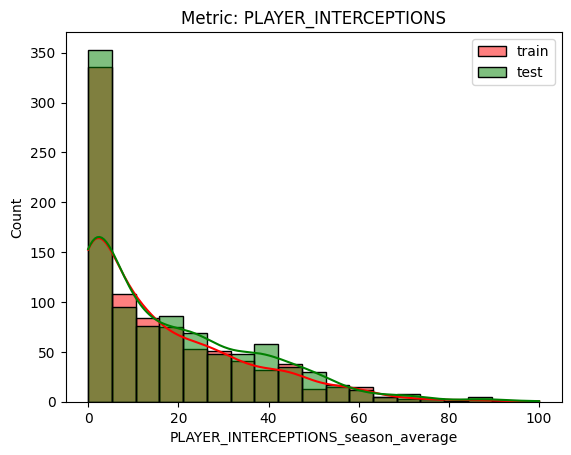

Metric: PLAYER_INTERCEPTIONS
Differences: {'l1_loss': {'loss_value': 0.0008278291812434029, 'estimated_typical_loss_value': 0.0025260784313725485, 'loss_value_normalized': 0.3277131742871213}, 'l2_loss': {'loss_value': 2.9970337027139356e-06, 'estimated_typical_loss_value': 1.8117843137254905e-05, 'loss_value_normalized': 0.16541890113368626}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 185907105361.11957, 'estimated_typical_loss_value': 301564563284.05884, 'loss_value_normalized': 0.616475302457883}}


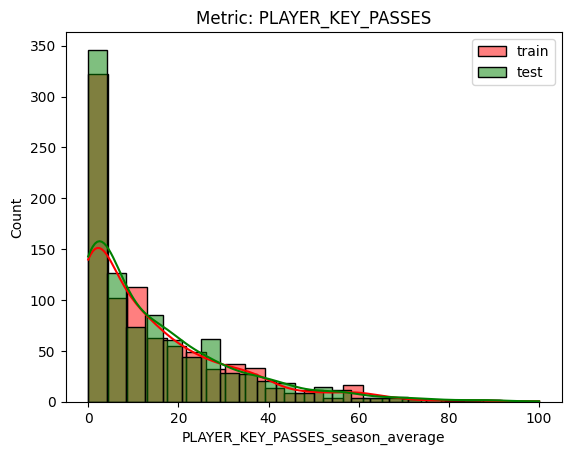

Metric: PLAYER_KEY_PASSES
Differences: {'l1_loss': {'loss_value': 0.0009175430359384945, 'estimated_typical_loss_value': 0.0023870588235294123, 'loss_value_normalized': 0.3843822476824286}, 'l2_loss': {'loss_value': 6.584647213135667e-06, 'estimated_typical_loss_value': 1.822549019607843e-05, 'loss_value_normalized': 0.361287797596372}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 92953552680.60283, 'estimated_typical_loss_value': 319667267668.5956, 'loss_value_normalized': 0.29078220412910505}}


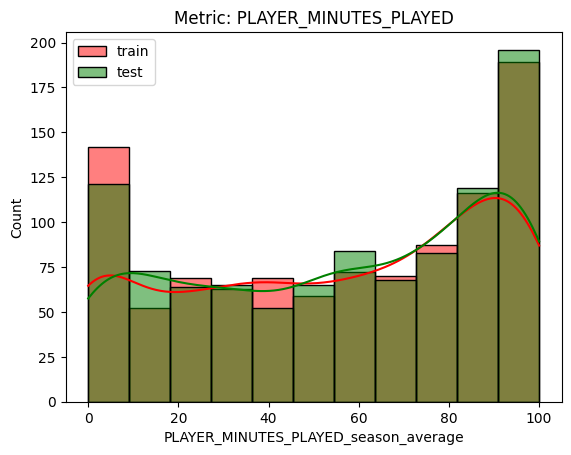

Metric: PLAYER_MINUTES_PLAYED
Differences: {'l1_loss': {'loss_value': 0.0008168531388345627, 'estimated_typical_loss_value': 0.0032447058823529417, 'loss_value_normalized': 0.25174951704471743}, 'l2_loss': {'loss_value': 9.489604525269705e-06, 'estimated_typical_loss_value': 1.9377254901960776e-05, 'loss_value_normalized': 0.48972904434470305}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.06693235384144235, 'estimated_typical_loss_value': 52983525028.37573, 'loss_value_normalized': 1.2632672855495404e-12}}


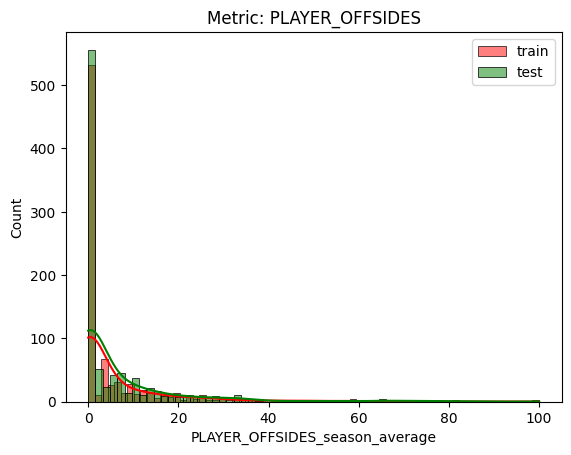

Metric: PLAYER_OFFSIDES
Differences: {'l1_loss': {'loss_value': 0.0010375459071583996, 'estimated_typical_loss_value': 0.0016300000000000002, 'loss_value_normalized': 0.6365312313854344}, 'l2_loss': {'loss_value': 8.77132267509214e-06, 'estimated_typical_loss_value': 1.3546470588235301e-05, 'loss_value_normalized': 0.6474987427770297}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 185907105361.10126, 'estimated_typical_loss_value': 466255020245.7182, 'loss_value_normalized': 0.39872408293454403}}


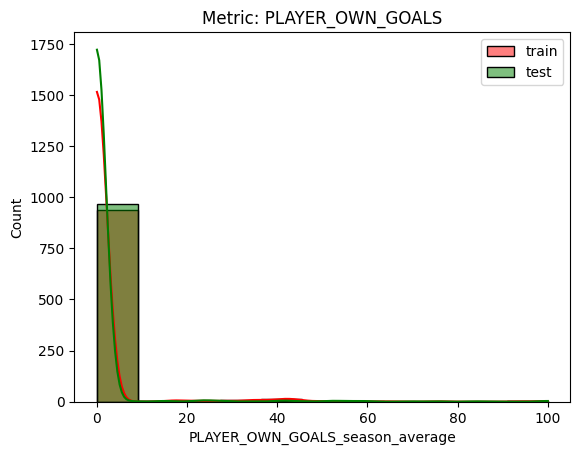

Metric: PLAYER_OWN_GOALS
Differences: {'l1_loss': {'loss_value': 0.000151111697952655, 'estimated_typical_loss_value': 0.00032490196078431376, 'loss_value_normalized': 0.4650993720929473}, 'l2_loss': {'loss_value': 6.584609675960275e-07, 'estimated_typical_loss_value': 1.2137254901960795e-06, 'loss_value_normalized': 0.5425122672254251}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04187865105335925, 'estimated_typical_loss_value': 320991855794.06604, 'loss_value_normalized': 1.3046639750332704e-13}}


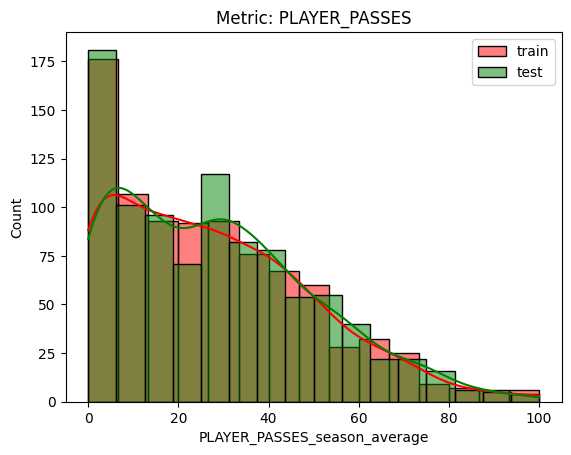

Metric: PLAYER_PASSES
Differences: {'l1_loss': {'loss_value': 0.0008127435094544327, 'estimated_typical_loss_value': 0.002965882352941176, 'loss_value_normalized': 0.2740309333741437}, 'l2_loss': {'loss_value': 7.244422357560221e-06, 'estimated_typical_loss_value': 1.9288039215686277e-05, 'loss_value_normalized': 0.37559143656163824}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 185907105361.1001, 'estimated_typical_loss_value': 275955859520.64307, 'loss_value_normalized': 0.6736842105256808}}


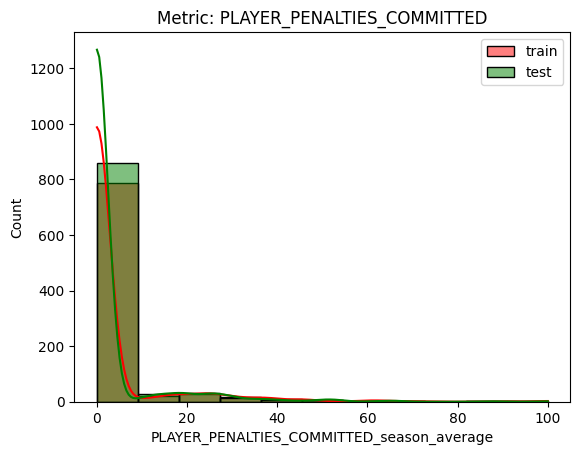

Metric: PLAYER_PENALTIES_COMMITTED
Differences: {'l1_loss': {'loss_value': 0.00029566504631018883, 'estimated_typical_loss_value': 0.0007805882352941177, 'loss_value_normalized': 0.3787721015276398}, 'l2_loss': {'loss_value': 1.717829493598956e-06, 'estimated_typical_loss_value': 3.5678431372549053e-06, 'loss_value_normalized': 0.481475621939406}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.08186564969450845, 'estimated_typical_loss_value': 396051849583.69745, 'loss_value_normalized': 2.067043741382852e-13}}


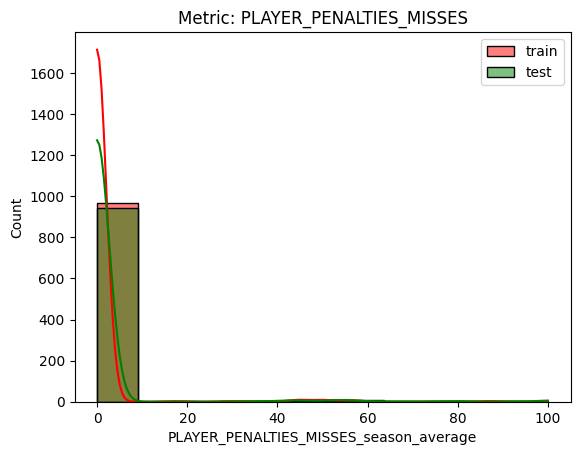

Metric: PLAYER_PENALTIES_MISSES
Differences: {'l1_loss': {'loss_value': 8.822260904862742e-05, 'estimated_typical_loss_value': 0.0002647058823529413, 'loss_value_normalized': 0.3332854119612016}, 'l2_loss': {'loss_value': 1.7482457806936383e-07, 'estimated_typical_loss_value': 9.892156862745108e-07, 'loss_value_normalized': 0.17673049513451342}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 45518492292.02938, 'estimated_typical_loss_value': 229153745745.69583, 'loss_value_normalized': 0.19863734779419093}}


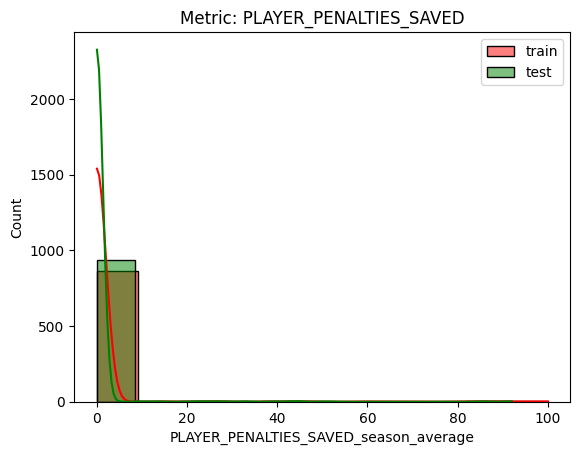

Metric: PLAYER_PENALTIES_SAVED
Differences: {'l1_loss': {'loss_value': 4.297416019759595e-05, 'estimated_typical_loss_value': 0.0001754901960784314, 'loss_value_normalized': 0.2448806893938123}, 'l2_loss': {'loss_value': 6.074282743352762e-08, 'estimated_typical_loss_value': 5.778431372549027e-07, 'loss_value_normalized': 0.10511992527721405}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.018865979627714868, 'estimated_typical_loss_value': 229153745745.67093, 'loss_value_normalized': 8.232891662462068e-14}}


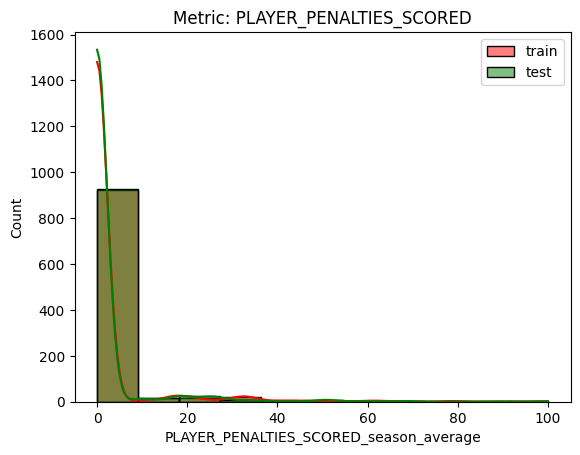

Metric: PLAYER_PENALTIES_SCORED
Differences: {'l1_loss': {'loss_value': 0.0001407662398374494, 'estimated_typical_loss_value': 0.0005470588235294116, 'loss_value_normalized': 0.25731463196082466}, 'l2_loss': {'loss_value': 1.605133380641567e-07, 'estimated_typical_loss_value': 2.2723529411764614e-06, 'loss_value_normalized': 0.0706375031536121}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.10674153191411417, 'estimated_typical_loss_value': 377949145199.10913, 'loss_value_normalized': 2.824230012688114e-13}}


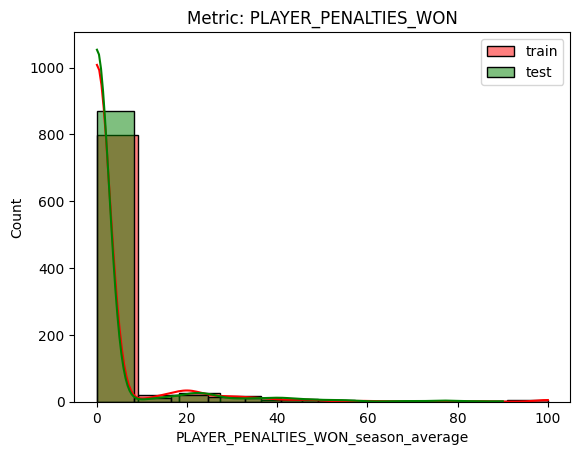

Metric: PLAYER_PENALTIES_WON
Differences: {'l1_loss': {'loss_value': 0.0002526908861125883, 'estimated_typical_loss_value': 0.0006827450980392158, 'loss_value_normalized': 0.3701101433583518}, 'l2_loss': {'loss_value': 3.1298557615204256e-07, 'estimated_typical_loss_value': 3.3856862745098067e-06, 'loss_value_normalized': 0.09244376198938611}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 371814210722.0685, 'estimated_typical_loss_value': 458749020866.68585, 'loss_value_normalized': 0.8104959221921022}}


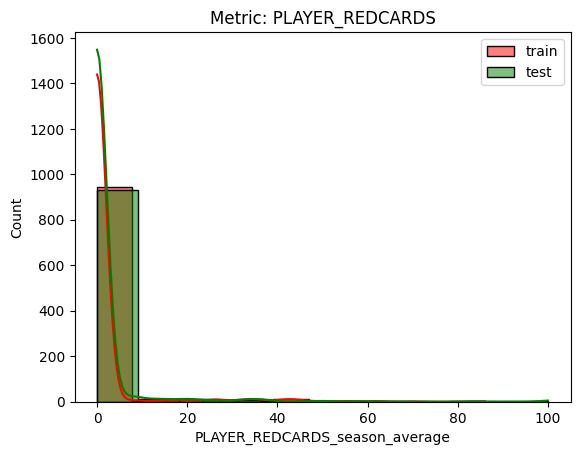

Metric: PLAYER_REDCARDS
Differences: {'l1_loss': {'loss_value': 0.0001580321667812457, 'estimated_typical_loss_value': 0.0004841176470588234, 'loss_value_normalized': 0.3264333943232011}, 'l2_loss': {'loss_value': 7.78743086738402e-07, 'estimated_typical_loss_value': 1.963529411764703e-06, 'loss_value_normalized': 0.39660372897111357}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 45471614339.104454, 'estimated_typical_loss_value': 423426670848.0414, 'loss_value_normalized': 0.10738958471376789}}


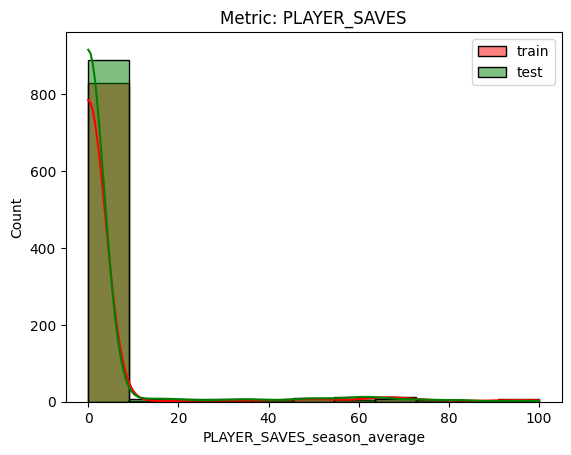

Metric: PLAYER_SAVES
Differences: {'l1_loss': {'loss_value': 0.00031992920795516534, 'estimated_typical_loss_value': 0.0006274509803921566, 'loss_value_normalized': 0.5098871751783646}, 'l2_loss': {'loss_value': 1.4424412678731934e-06, 'estimated_typical_loss_value': 2.6274509803921478e-06, 'loss_value_normalized': 0.548988840711315}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 557721316083.0878, 'estimated_typical_loss_value': 634919241584.4109, 'loss_value_normalized': 0.8784130005121922}}


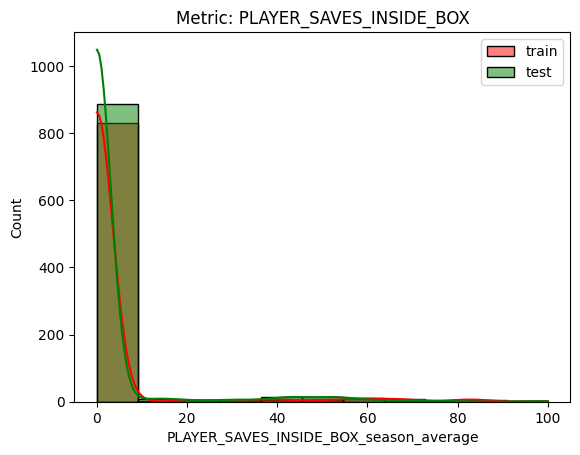

Metric: PLAYER_SAVES_INSIDE_BOX
Differences: {'l1_loss': {'loss_value': 0.00028898122292787213, 'estimated_typical_loss_value': 0.0006023529411764703, 'loss_value_normalized': 0.4797539833761736}, 'l2_loss': {'loss_value': 1.4583152445958518e-06, 'estimated_typical_loss_value': 2.502549019607834e-06, 'loss_value_normalized': 0.5827319397303902}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 325337434381.8284, 'estimated_typical_loss_value': 596064656563.9512, 'loss_value_normalized': 0.5458089668615057}}


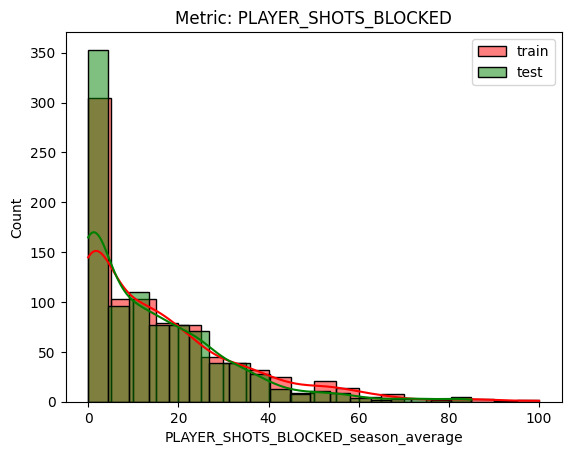

Metric: PLAYER_SHOTS_BLOCKED
Differences: {'l1_loss': {'loss_value': 0.0010227191158525464, 'estimated_typical_loss_value': 0.0023499999999999997, 'loss_value_normalized': 0.43519962376699994}, 'l2_loss': {'loss_value': 6.280021183014564e-06, 'estimated_typical_loss_value': 1.7526666666666666e-05, 'loss_value_normalized': 0.35831235353375823}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.1447397455363384, 'estimated_typical_loss_value': 387221262079.1502, 'loss_value_normalized': 3.7379080053396646e-13}}


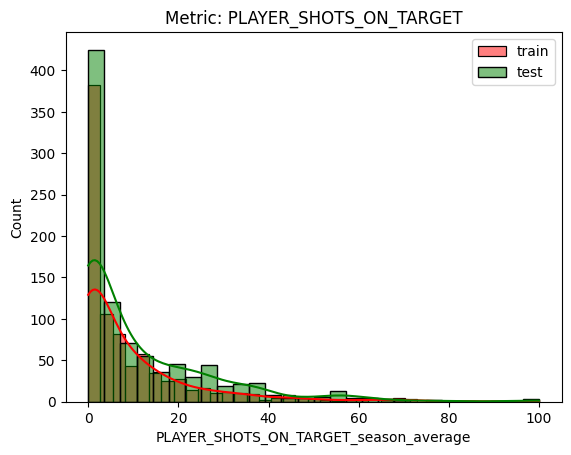

Metric: PLAYER_SHOTS_ON_TARGET
Differences: {'l1_loss': {'loss_value': 0.0013659240326989585, 'estimated_typical_loss_value': 0.0020670588235294123, 'loss_value_normalized': 0.6608055935082469}, 'l2_loss': {'loss_value': 5.524209179961577e-06, 'estimated_typical_loss_value': 1.5650000000000008e-05, 'loss_value_normalized': 0.35298461213311155}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 232383881701.45956, 'estimated_typical_loss_value': 377949145199.23987, 'loss_value_normalized': 0.614854894244981}}


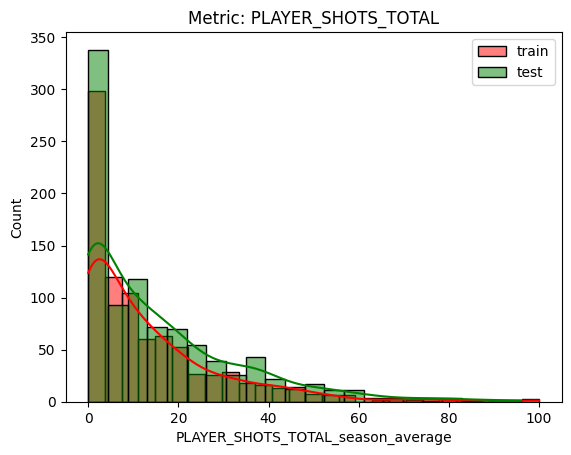

Metric: PLAYER_SHOTS_TOTAL
Differences: {'l1_loss': {'loss_value': 0.0011631500106494025, 'estimated_typical_loss_value': 0.0023807843137254904, 'loss_value_normalized': 0.48855749088382466}, 'l2_loss': {'loss_value': 3.6177117121737635e-06, 'estimated_typical_loss_value': 1.8065686274509806e-05, 'loss_value_normalized': 0.20025321248015868}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 185907105361.21594, 'estimated_typical_loss_value': 369560087069.8535, 'loss_value_normalized': 0.5030497390430481}}


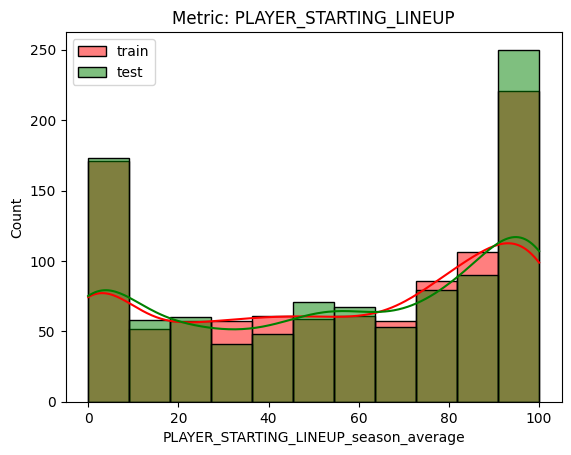

Metric: PLAYER_STARTING_LINEUP
Differences: {'l1_loss': {'loss_value': 0.0008803202301654312, 'estimated_typical_loss_value': 0.0027972549019607846, 'loss_value_normalized': 0.3147086200647233}, 'l2_loss': {'loss_value': 6.962810218794175e-06, 'estimated_typical_loss_value': 1.7445098039215685e-05, 'loss_value_normalized': 0.3991270328807273}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.11257374047888394, 'estimated_typical_loss_value': 296266210781.4185, 'loss_value_normalized': 3.7997495624615604e-13}}


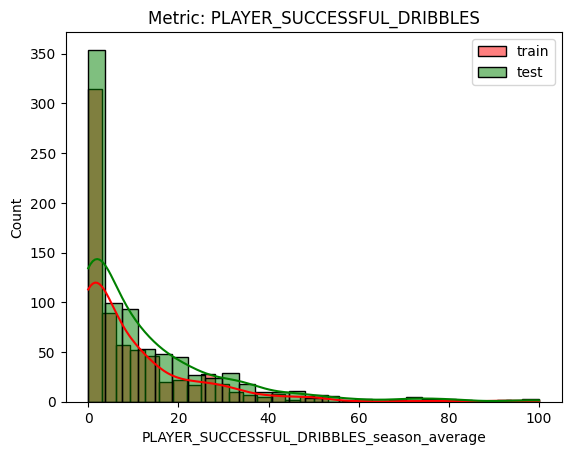

Metric: PLAYER_SUCCESSFUL_DRIBBLES
Differences: {'l1_loss': {'loss_value': 0.0015082515139860685, 'estimated_typical_loss_value': 0.0020449019607843137, 'loss_value_normalized': 0.7375666623193129}, 'l2_loss': {'loss_value': 2.4461905809404634e-05, 'estimated_typical_loss_value': 1.6095098039215697e-05, 'loss_value_normalized': 1.5198357754308638}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 515805344897.8056, 'estimated_typical_loss_value': 339094560178.77405, 'loss_value_normalized': 1.5211253894072139}}


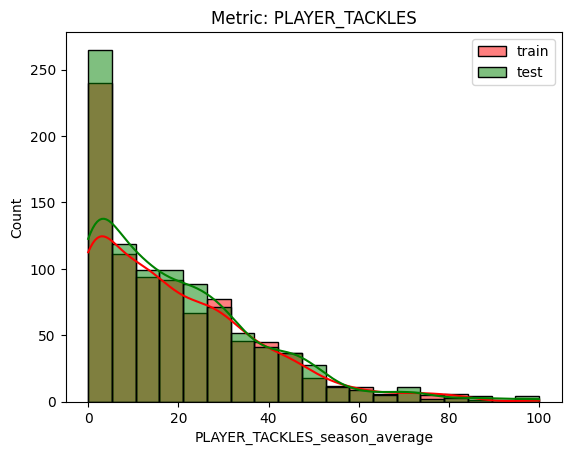

Metric: PLAYER_TACKLES
Differences: {'l1_loss': {'loss_value': 0.0006561914209361352, 'estimated_typical_loss_value': 0.0025829411764705878, 'loss_value_normalized': 0.2540481474815154}, 'l2_loss': {'loss_value': 1.3461673826114925e-06, 'estimated_typical_loss_value': 1.876549019607843e-05, 'loss_value_normalized': 0.07173632921547037}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 232383881701.34225, 'estimated_typical_loss_value': 360287970189.9816, 'loss_value_normalized': 0.6449948400408847}}


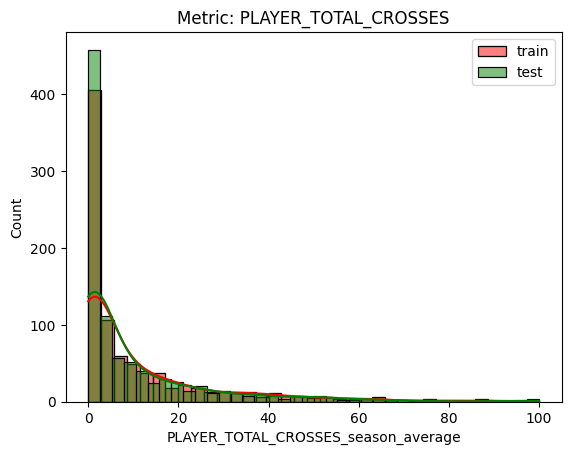

Metric: PLAYER_TOTAL_CROSSES
Differences: {'l1_loss': {'loss_value': 0.0007560486836515801, 'estimated_typical_loss_value': 0.0020486274509803923, 'loss_value_normalized': 0.36905132911778715}, 'l2_loss': {'loss_value': 3.917541731105616e-06, 'estimated_typical_loss_value': 1.5021960784313722e-05, 'loss_value_normalized': 0.26078764199268156}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.09286151484177127, 'estimated_typical_loss_value': 494512900260.668, 'loss_value_normalized': 1.877838066364336e-13}}


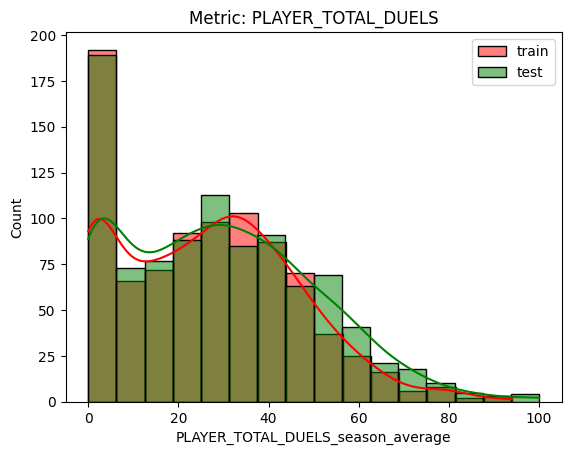

Metric: PLAYER_TOTAL_DUELS
Differences: {'l1_loss': {'loss_value': 0.0010396404856127175, 'estimated_typical_loss_value': 0.0027976470588235297, 'loss_value_normalized': 0.37161245280518906}, 'l2_loss': {'loss_value': 1.260267984445599e-05, 'estimated_typical_loss_value': 1.8511568627450975e-05, 'loss_value_normalized': 0.6808002119072822}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 371814210722.1506, 'estimated_typical_loss_value': 245931862004.7912, 'loss_value_normalized': 1.5118586412154558}}


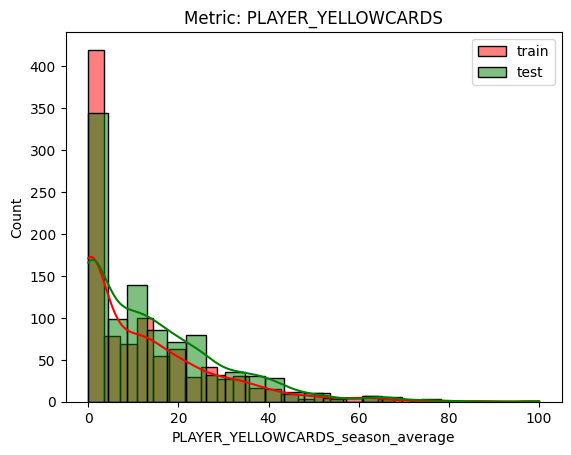

Metric: PLAYER_YELLOWCARDS
Differences: {'l1_loss': {'loss_value': 0.001822543927807086, 'estimated_typical_loss_value': 0.002045686274509804, 'loss_value_normalized': 0.890920543641822}, 'l2_loss': {'loss_value': 7.714858445279694e-05, 'estimated_typical_loss_value': 1.6007647058823525e-05, 'loss_value_normalized': 4.8194830988107}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.11832742060819804, 'estimated_typical_loss_value': 341743736430.1743, 'loss_value_normalized': 3.4624605514130586e-13}}


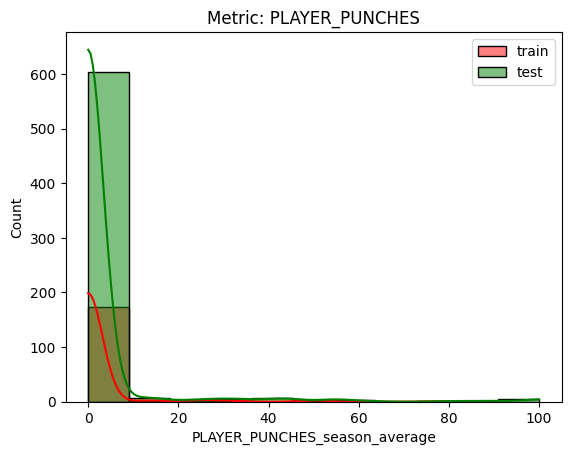

Metric: PLAYER_PUNCHES
Differences: {'l1_loss': {'loss_value': 0.0006750744116112795, 'estimated_typical_loss_value': 0.0004011764705882351, 'loss_value_normalized': 1.6827368031356897}, 'l2_loss': {'loss_value': 2.821222361892397e-06, 'estimated_typical_loss_value': 1.9939215686274464e-06, 'loss_value_normalized': 1.4149114017158986}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 1520132434289.9895, 'estimated_typical_loss_value': 144821635076.3345, 'loss_value_normalized': 10.496583839070302}}


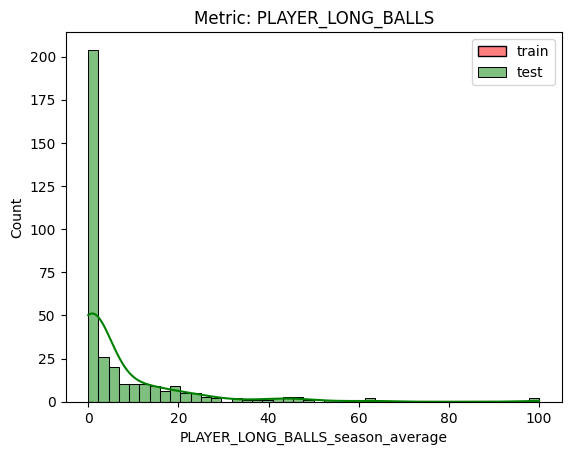

Metric: PLAYER_LONG_BALLS
Differences: {'l1_loss': {'loss_value': 0.014422081629960249, 'estimated_typical_loss_value': 0.0024478431372549026, 'loss_value_normalized': 5.891750745978098}, 'l2_loss': {'loss_value': 0.0031281482139289152, 'estimated_typical_loss_value': 1.592607843137254e-05, 'loss_value_normalized': 196.41672790730516}, 'kl_divergence': {'loss_value': inf, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 1.471052326255912, 'estimated_typical_loss_value': 41062231896.92666, 'loss_value_normalized': 3.582494809216677e-11}}


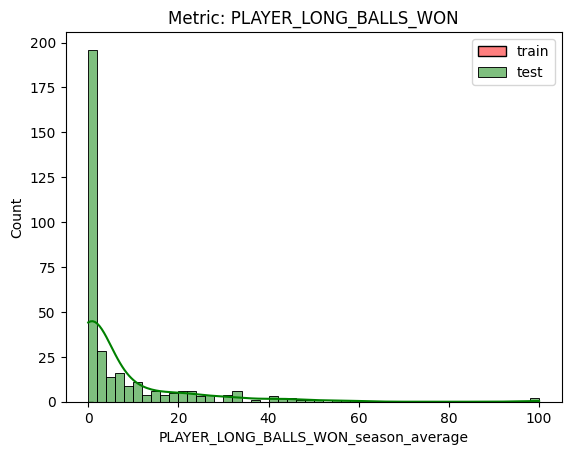

Metric: PLAYER_LONG_BALLS_WON
Differences: {'l1_loss': {'loss_value': 0.013939791022569831, 'estimated_typical_loss_value': 0.002504509803921569, 'loss_value_normalized': 5.565876005253255}, 'l2_loss': {'loss_value': 0.0032790121027777576, 'estimated_typical_loss_value': 1.5626078431372548e-05, 'loss_value_normalized': 209.84229134213714}, 'kl_divergence': {'loss_value': inf, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 1.4218586843020904, 'estimated_typical_loss_value': 33556232517.98816, 'loss_value_normalized': 4.237241721161303e-11}}


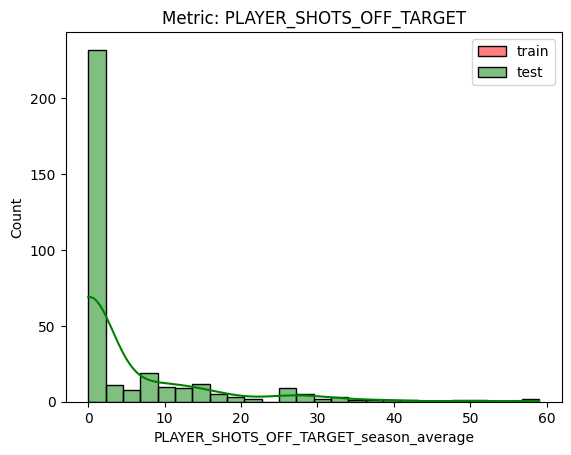

Metric: PLAYER_SHOTS_OFF_TARGET
Differences: {'l1_loss': {'loss_value': 0.014962383607579238, 'estimated_typical_loss_value': 0.002371176470588236, 'loss_value_normalized': 6.310109683175965}, 'l2_loss': {'loss_value': 0.004489870732844399, 'estimated_typical_loss_value': 1.4379803921568623e-05, 'loss_value_normalized': 312.2344892367135}, 'kl_divergence': {'loss_value': inf, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 1.5261631279730474, 'estimated_typical_loss_value': 56074230654.83148, 'loss_value_normalized': 2.7216835793386846e-11}}


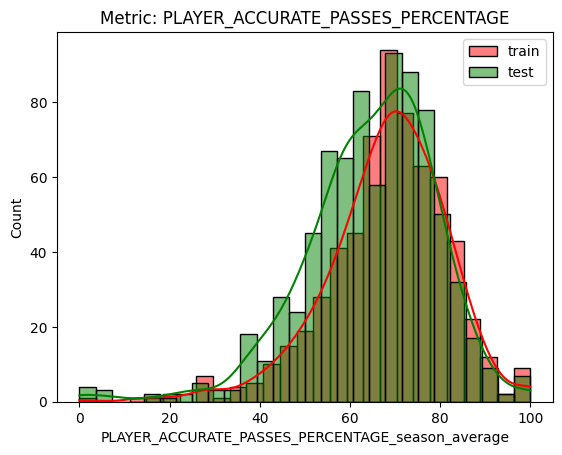

Metric: PLAYER_ACCURATE_PASSES_PERCENTAGE
Differences: {'l1_loss': {'loss_value': 0.001094409660430232, 'estimated_typical_loss_value': 0.0026247058823529418, 'loss_value_normalized': 0.41696468461031744}, 'l2_loss': {'loss_value': 3.644872610503139e-06, 'estimated_typical_loss_value': 1.8986862745098043e-05, 'loss_value_normalized': 0.1919681339352144}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 221317982572.76382, 'estimated_typical_loss_value': 256970096385.5476, 'loss_value_normalized': 0.861259678405176}}


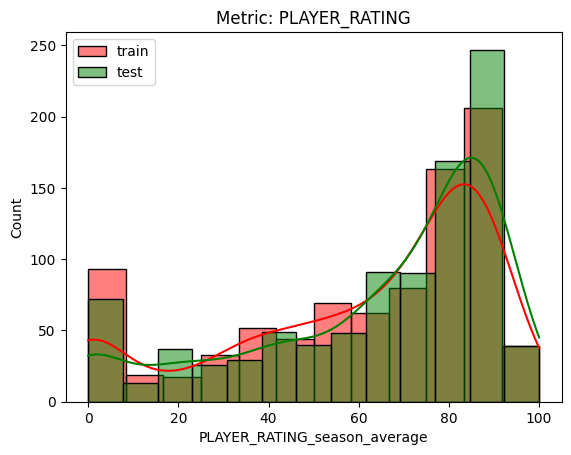

Metric: PLAYER_RATING
Differences: {'l1_loss': {'loss_value': 0.0013923769111557486, 'estimated_typical_loss_value': 0.002979019607843137, 'loss_value_normalized': 0.4673943425849924}, 'l2_loss': {'loss_value': 1.2572150017515646e-05, 'estimated_typical_loss_value': 1.9291960784313723e-05, 'loss_value_normalized': 0.6516781864699491}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.2016762336538255, 'estimated_typical_loss_value': 338211501428.4995, 'loss_value_normalized': 5.963021151025563e-13}}


In [12]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference

column_names_to_fn_names = get_metrics_names_to_fn_names(df_playersfeatures_train)
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    # Compute the distribution difference
    column_name = f"{metric_name}_season_average"
    loss_name_to_loss_values = compute_distribution_difference(
        feature_serie1=df_playersfeatures_train[column_name],
        feature_serie2=df_playersfeatures_test[column_name],
        n_monte_carlo=50,
        n_value_max=101,
        )
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    sns.histplot(df_playersfeatures_train[column_name], kde=True, label="train", color="red")
    sns.histplot(df_playersfeatures_test[column_name], kde=True, label="test", color="green")
    plt.legend()
    plt.show()
    print(f"Metric: {metric_name}")
    print(f"Differences: {loss_name_to_loss_values}")

# Conclusion

Visually, the distributions look the same.
Numerically, some results should make us carefull with some metrics.